**Goals** 
Perform an Exploratory Data Analysis (EDA) to visualize and understand:

* The distribution of values of the target and features;
* The relationship between each feature and the likelihood of customer churn.

Predict churn using 20% of data as test set using the following models:

* Logistic Regression;
* Random Forest;
* XGBoost;

Understand how each feature impacts the predicted value using:

* Feature Importance;
* SHAP.

The data set includes information about:

* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

# **Import libraries**

In [1]:
import pandas as pd 
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
from scipy import stats # statistic library

%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from catboost import Pool

import shap

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

# **Reading Data**

In [2]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
import pandas as pd
import scipy.stats as stats

def data_summarization(df):
    print(f"Dataset Shape: {df.shape}")
    
    # Create the initial summary DataFrame
    summary = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name', 'dtypes']]
    
    # Add columns for missing values, unique values count, and unique values
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values




    # Calculate entropy for each column
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=10), 2)

    return summary


In [5]:
summarization = data_summarization(df)
summarization

Dataset Shape: (7043, 21)


,Name,dtypes,Missing,Uniques,Entropy
0,customerID,object,0,7043,3.85
1,gender,object,0,2,0.30
2,SeniorCitizen,int64,0,2,0.19
3,Partner,object,0,2,0.30
4,Dependents,object,0,2,0.27
5,tenure,int64,0,73,1.78
6,PhoneService,object,0,2,0.14
7,MultipleLines,object,0,3,0.41
8,InternetService,object,0,3,0.46
9,OnlineSecurity,object,0,3,0.45


In [8]:
uniques = pd.DataFrame(columns=['first_value', 'second_value', 'third_value'])

for i in df.columns:
    if len(df[i].unique()) == 2:
        first_value = df[i].unique()[0]
        second_value = df[i].unique()[1]
        third_value = "#"
    elif len(df[i].unique()) == 3:
        first_value = df[i].unique()[0]
        second_value = df[i].unique()[1]
        third_value = df[i].unique()[2]
    else:
        first_value = df[i].unique()[0]
        second_value = df[i].unique()[1]
        third_value = df[i].unique()[2]
    
    uniques.loc[i] = [first_value, second_value, third_value]

uniques

,first_value,second_value,third_value
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK
gender,Female,Male,#
SeniorCitizen,0,1,#
Partner,Yes,No,#
Dependents,No,Yes,#
tenure,1,34,2
PhoneService,No,Yes,#
MultipleLines,No phone service,No,Yes
InternetService,DSL,Fiber optic,No
OnlineSecurity,No,Yes,No internet service


In [9]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].dtype

dtype('float64')

In [10]:
df['TotalCharges'].isnull().sum()

11

Now there are supposedly 11 missing values, but they might indicate that there were no charges for that customer up to the point when the data was obtained. The feature 'tenure' indicates for how long someone has been a customer. Let's check the number of samples with value '0' on that feature and, in case we also find 11 customers, compare if their index match those from the 'missing' values.

In [11]:
df['tenure'].isin([0]).sum()

11

In [12]:
print(df[df['tenure'].isin([0])].index)
print(df[df['TotalCharges'].isna()].index)

Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')
Index([488, 753, 936, 1082, 1340, 3331, 3826, 4380, 5218, 6670, 6754], dtype='int64')


In [13]:
df.loc[:,'TotalCharges'] = df.loc[:,'TotalCharges'].replace(np.nan,0)
df['TotalCharges'].isnull().sum()

0

The feature 'Senior Citizen', which is categorical ('Yes' or 'No'), is set as numeric. Although all features will be changed to numeric to be used in our prediction models, I'll convert it from numeric to string for now.

In [14]:
df['SeniorCitizen'] = df['SeniorCitizen'].apply(str)
senior_map = {'0': 'No', '1': 'Yes'}
df['SeniorCitizen'] = df['SeniorCitizen'].map(senior_map)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [15]:
for col in df.select_dtypes('object').columns:
    print(col, '\n')
    print(df[col].value_counts(), '\n')

customerID 

customerID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
4501-VCPFK    1
6075-SLNIL    1
             ..
1452-KIOVK    1
6713-OKOMC    1
7892-POOKP    1
6388-TABGU    1
9763-GRSKD    1
Name: count, Length: 7043, dtype: int64 

gender 

gender
Male      3555
Female    3488
Name: count, dtype: int64 

SeniorCitizen 

SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64 

Partner 

Partner
No     3641
Yes    3402
Name: count, dtype: int64 

Dependents 

Dependents
No     4933
Yes    2110
Name: count, dtype: int64 

PhoneService 

PhoneService
Yes    6361
No      682
Name: count, dtype: int64 

MultipleLines 

MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64 

InternetService 

InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64 

OnlineSecurity 

OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name:

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.35,89.85,118.75
TotalCharges,7043.0,2279.734304,2266.794470,0.00,398.55,1394.55,3786.60,8684.80


# **Exploratory Data Analysis**

We will start our EDA by looking at the distribution of the target variable (Churn). It’s expected that the dataset is imbalanced, with less than 50% of the customers leaving the company.

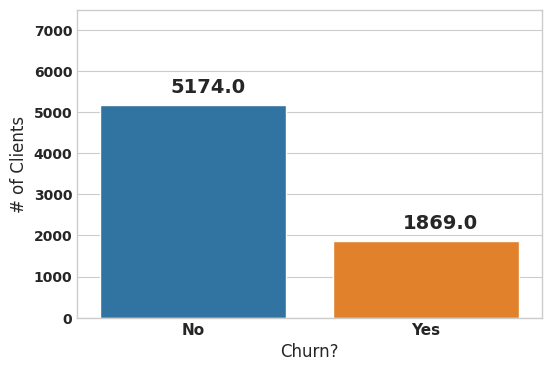

In [22]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x="Churn", data=df)

plt.xlabel("Churn?", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,7500)
plt.xticks([0,1], ['No', 'Yes'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 14)
    
plt.show()

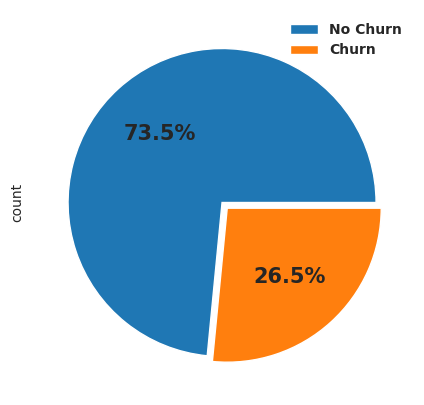

In [18]:
plt.figure(figsize=(7,5))

df['Churn'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['No Churn', 'Churn'])
plt.show()

At the period represented in this dataset, there is a 26,5% rate of customer churn. As we move on to analyze the features, we can compare this number with the percentage of churn found for each category, providing us a better idea on the impact of a given feature in the company’s ability to retain its customers.

In [23]:
#Label encoding Churn to use sns.barplot
le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
df['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

We can divide the features into the following groups:

* Demographic features;
* Service-related features
* Account information related features (categorical and numerical).

For each group, we’ll start by looking at the features’ distributions. Then, we’ll check the percentage of churn for each category to understand their relationship with the target.

In [24]:
demo_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

serv_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup'
                , 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

cat_accinfo_features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

num_accinfo_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# **DemoGraphic Features**

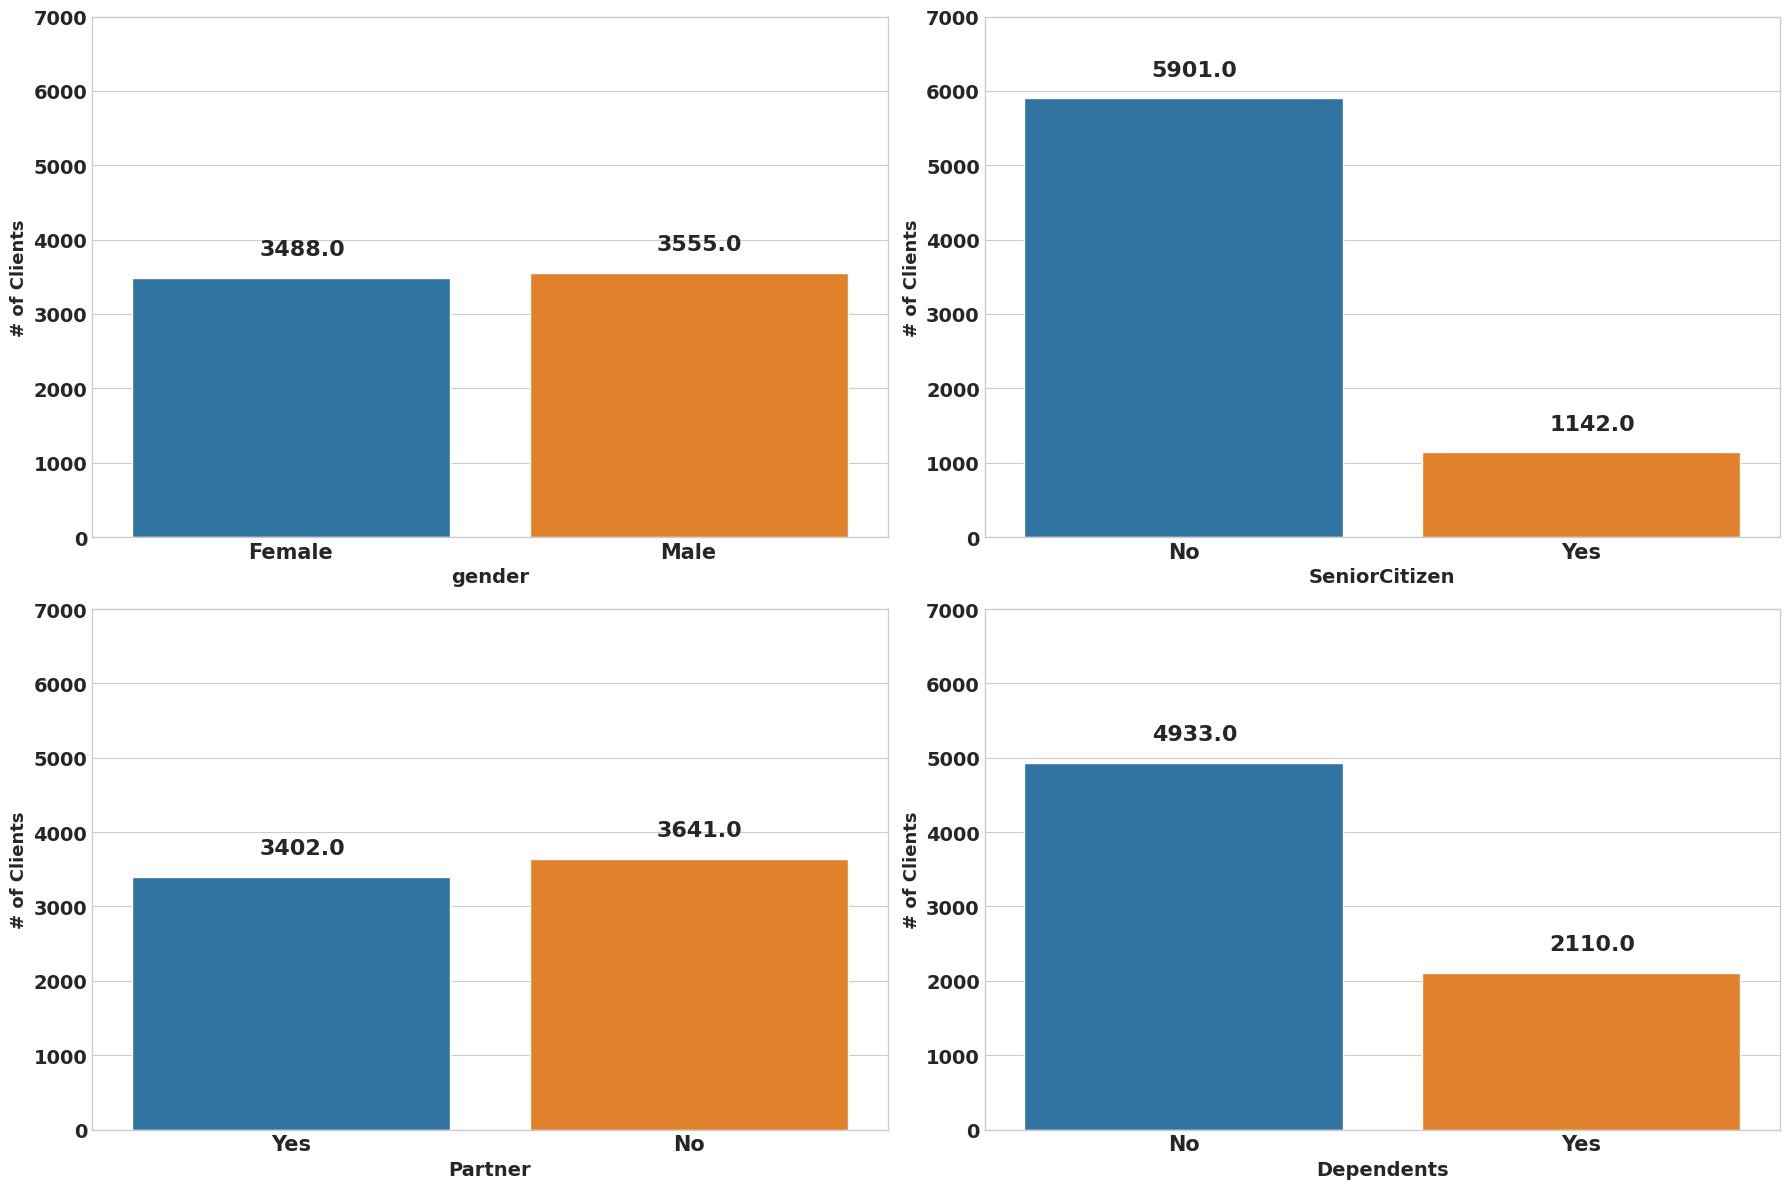

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 12))

for i, col in enumerate(demo_features):    
    plt.subplot(2, 2, i + 1)
    
    ax = sns.countplot(data=df, x=col)

    plt.xlabel(col, fontsize=14, fontweight='bold')
    plt.ylabel("# of Clients", fontsize=13, fontweight='bold')
    plt.ylim(0, 7000)
    plt.xticks(fontsize=15, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')

    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x() + 0.32, p.get_height() + 300), fontsize=16)

plt.tight_layout()

plt.show()


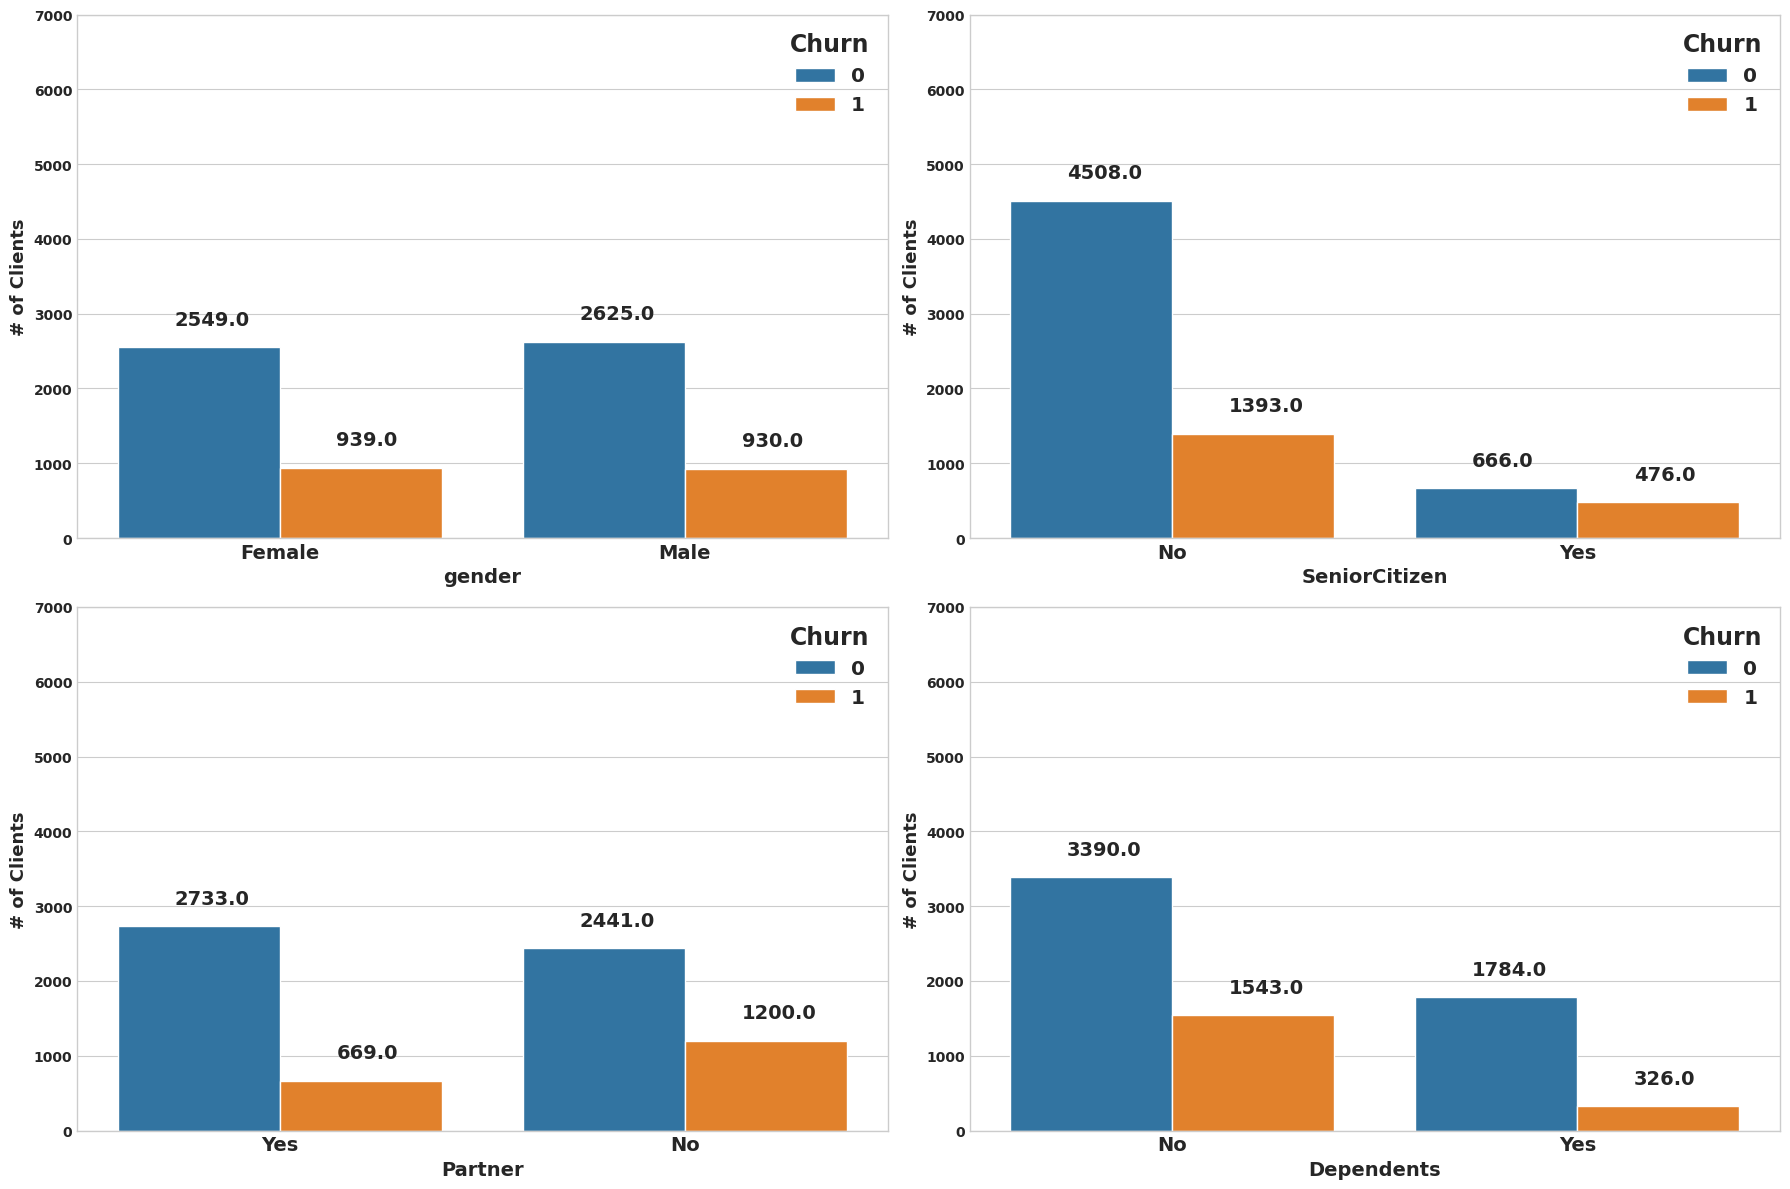

In [29]:
plt.figure(figsize=(18,12))

for i,col in enumerate(demo_features):    
    plt.subplot(2,2,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn")

    plt.xlabel(col, fontsize= 14 , fontweight='bold')
    plt.ylabel("# of Clients", fontsize= 13 , fontweight='bold')
    
    plt.ylim(0,7000)
    plt.xticks(fontsize= 14 , fontweight='bold')
    
    plt.legend(title = 'Churn', fontsize='x-large', title_fontsize='17')
    
    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.14, p.get_height()+300), fontsize= 14)

plt.tight_layout()

plt.show()

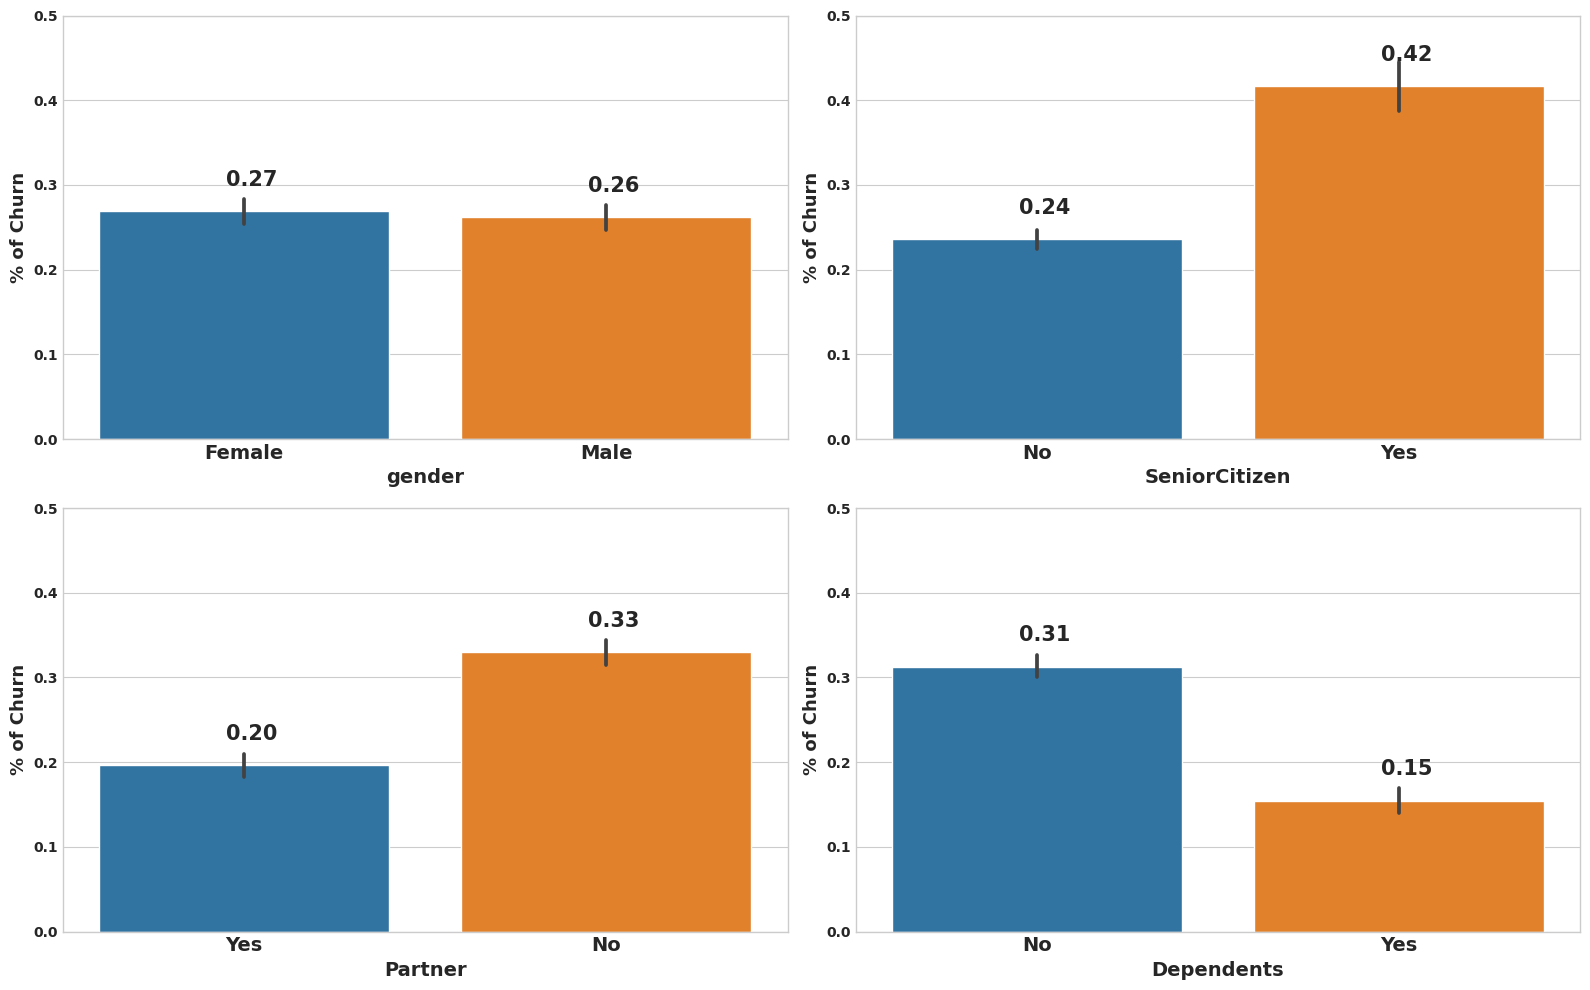

In [30]:
plt.figure(figsize=(16,10))

for i,col in enumerate(demo_features):    
    plt.subplot(2,2,i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df)

    plt.xlabel(col, fontsize= 14 ,  fontweight='bold')
    plt.ylabel("% of Churn", fontsize= 13 ,  fontweight='bold')
    plt.ylim(0,0.5)
    plt.xticks(fontsize= 14 ,  fontweight='bold')

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.35, p.get_height()+0.03),fontsize=15)

plt.tight_layout()

plt.show()

What we can observe for each feature:

* Gender: There is barely any difference in churn percentage between men and women;
* Senior Citizen: The churn percentage for senior customers are above 40%, indicating a high likelihood of churn from that group;
* Partner: Single customers are more likely to churn than customers with partners;
* Dependents: Customers with dependents are less likely to churn than customers without any dependents.

We could go a little further and combine the two ‘family-related’ features, ‘Partner’ and ‘Dependents’ to see if, in fact, both of them contribute to the chance of customer churn or retention.

It is expected that the majority of customers with dependents are married and, for instance, it could be that the partnership has more influence on the target than the fact that a customer has or hasn’t a child. Although this might be unlikely, by analyzing both features together, we can discard such hypothesis with more confidence.

In [31]:
df.groupby(['Partner'])['Dependents'].value_counts()

Partner  Dependents
No       No            3280
         Yes            361
Yes      Yes           1749
         No            1653
Name: count, dtype: int64

In [32]:
df.groupby(by=['Partner', 'Dependents'])['Churn'].value_counts(normalize = True)

Partner  Dependents  Churn
No       No          0        0.657622
                     1        0.342378
         Yes         0        0.786704
                     1        0.213296
Yes      No          0        0.745917
                     1        0.254083
         Yes         0        0.857633
                     1        0.142367
Name: proportion, dtype: float64

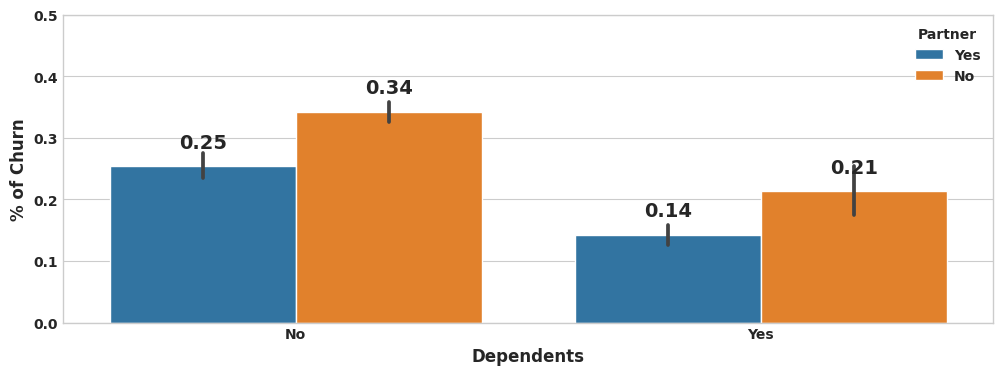

In [34]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "Dependents", y = "Churn", hue = "Partner", data = df)

plt.ylabel("% of Churn", fontsize= 12 , fontweight='bold')
plt.xlabel("Dependents", fontsize= 12 , fontweight='bold')

plt.ylim(0,0.5)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.15, p.get_height()+0.03),fontsize=14)

plt.show()

# **Customer Services**

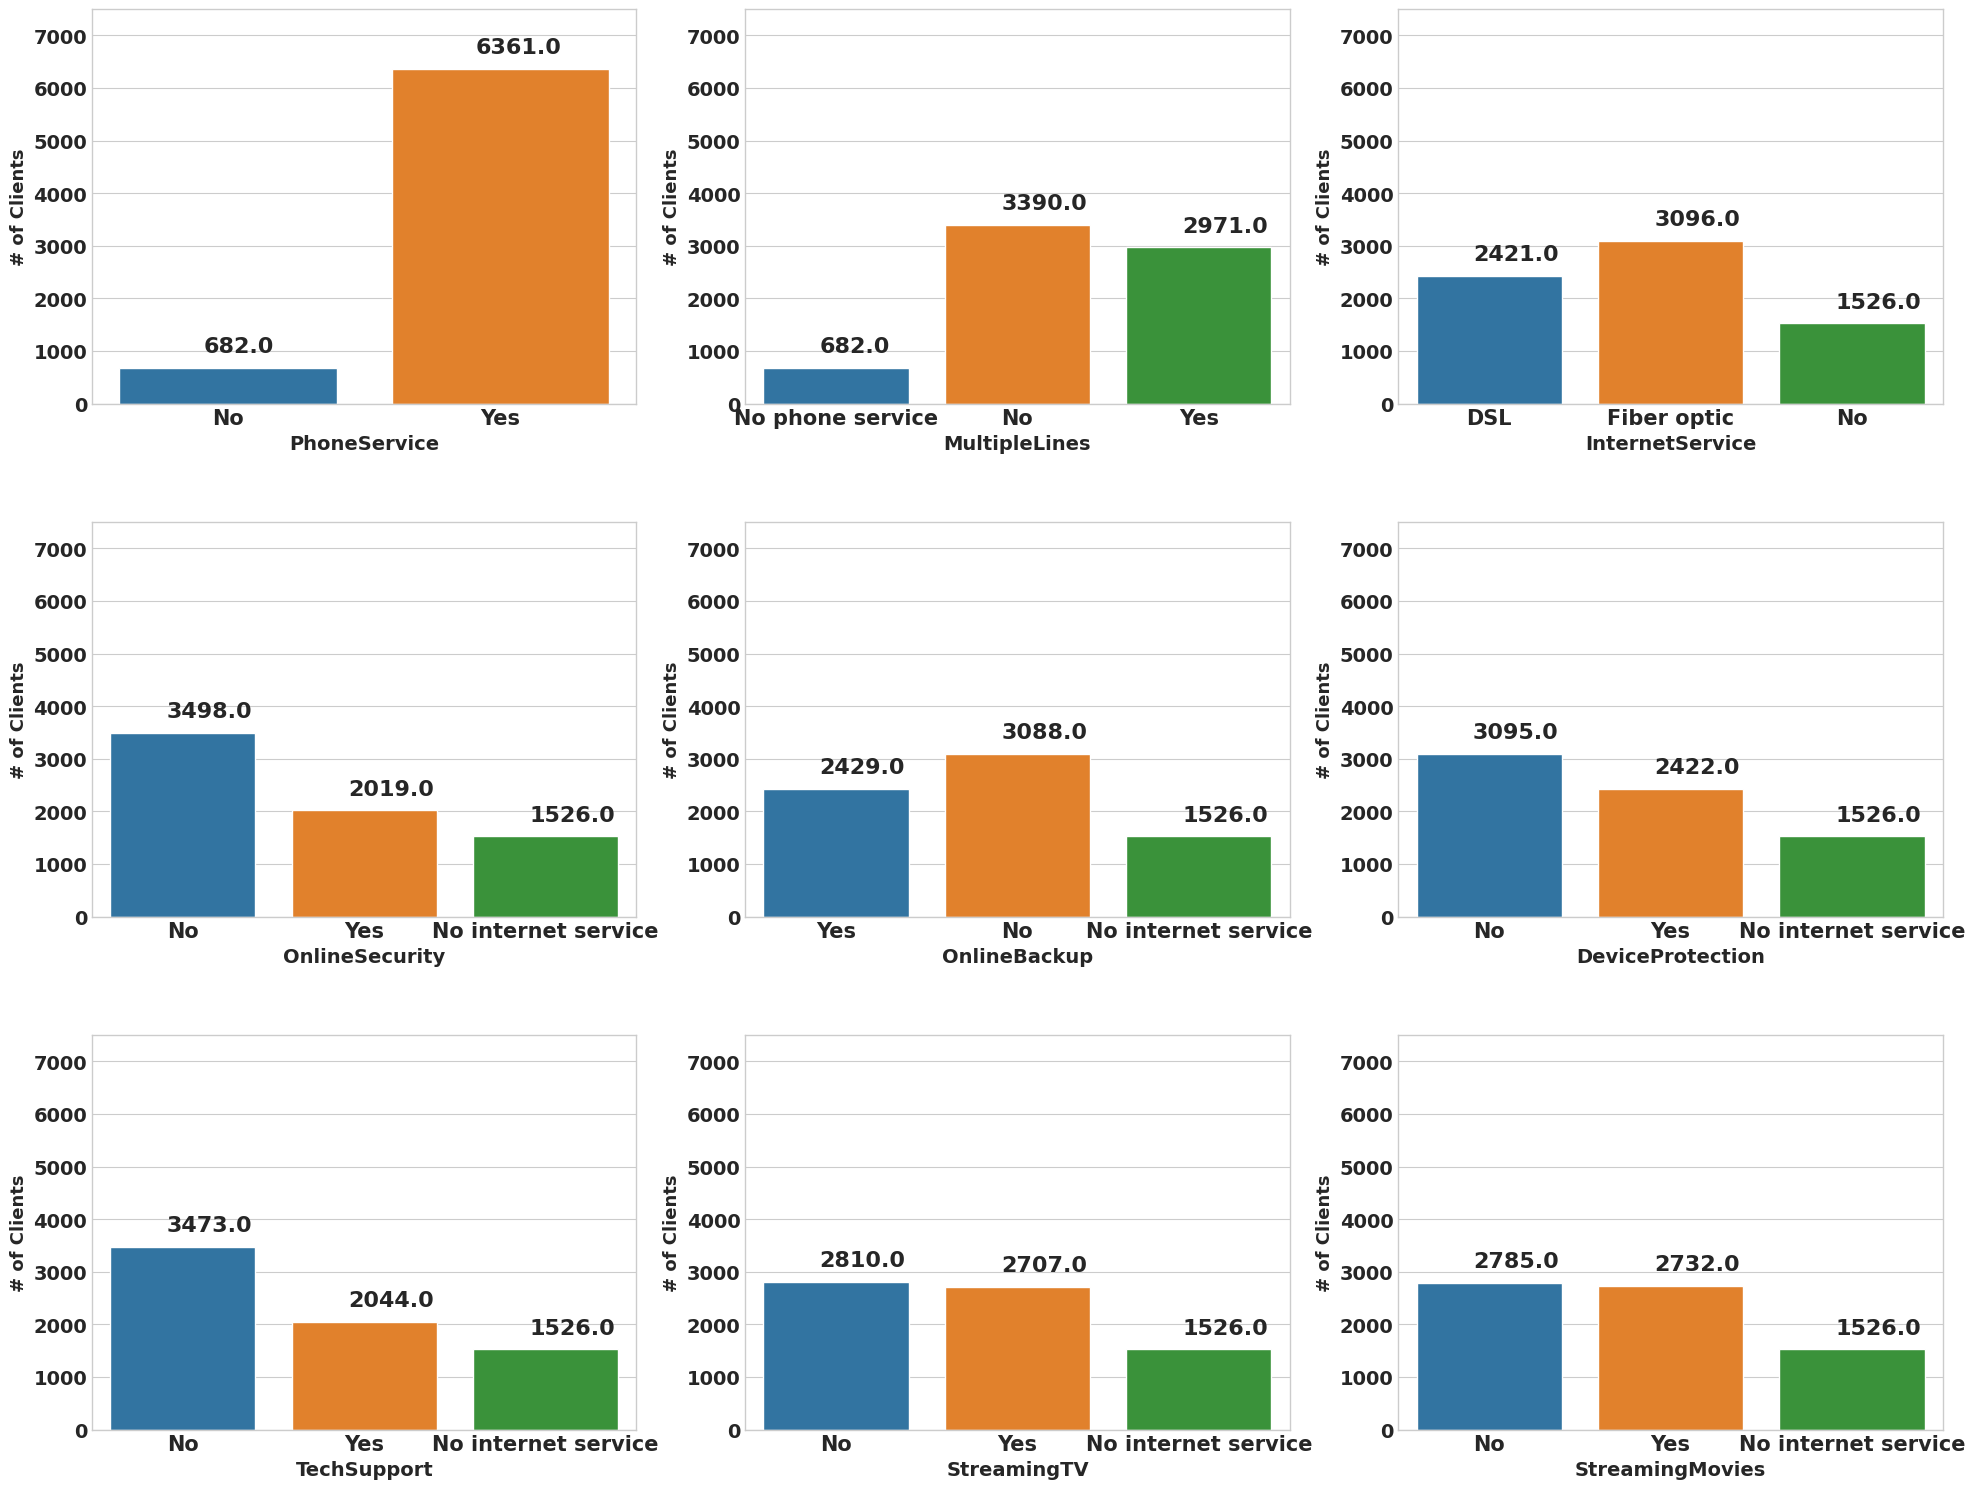

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))

for i, col in enumerate(serv_features):    
    plt.subplot(3, 3, i + 1)
    
    ax = sns.countplot(data=df, x=col)

    plt.xlabel(col, fontsize=14, fontweight='bold')
    plt.ylabel("# of Clients", fontsize=13, fontweight='bold')
    plt.ylim(0, 7500)
    plt.xticks(fontsize=15, fontweight='bold')
    plt.yticks(fontsize=14, fontweight='bold')

    for p in ax.patches:
        ax.annotate(p.get_height(), (p.get_x() + 0.31, p.get_height() + 300), fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()


A relatively small group of customers doesn’t have internet services and an even smaller one doesn’t have phone services. One thing to keep in mind is that most services can be and/or are only provided to customers who sign the Telco’s internet service.

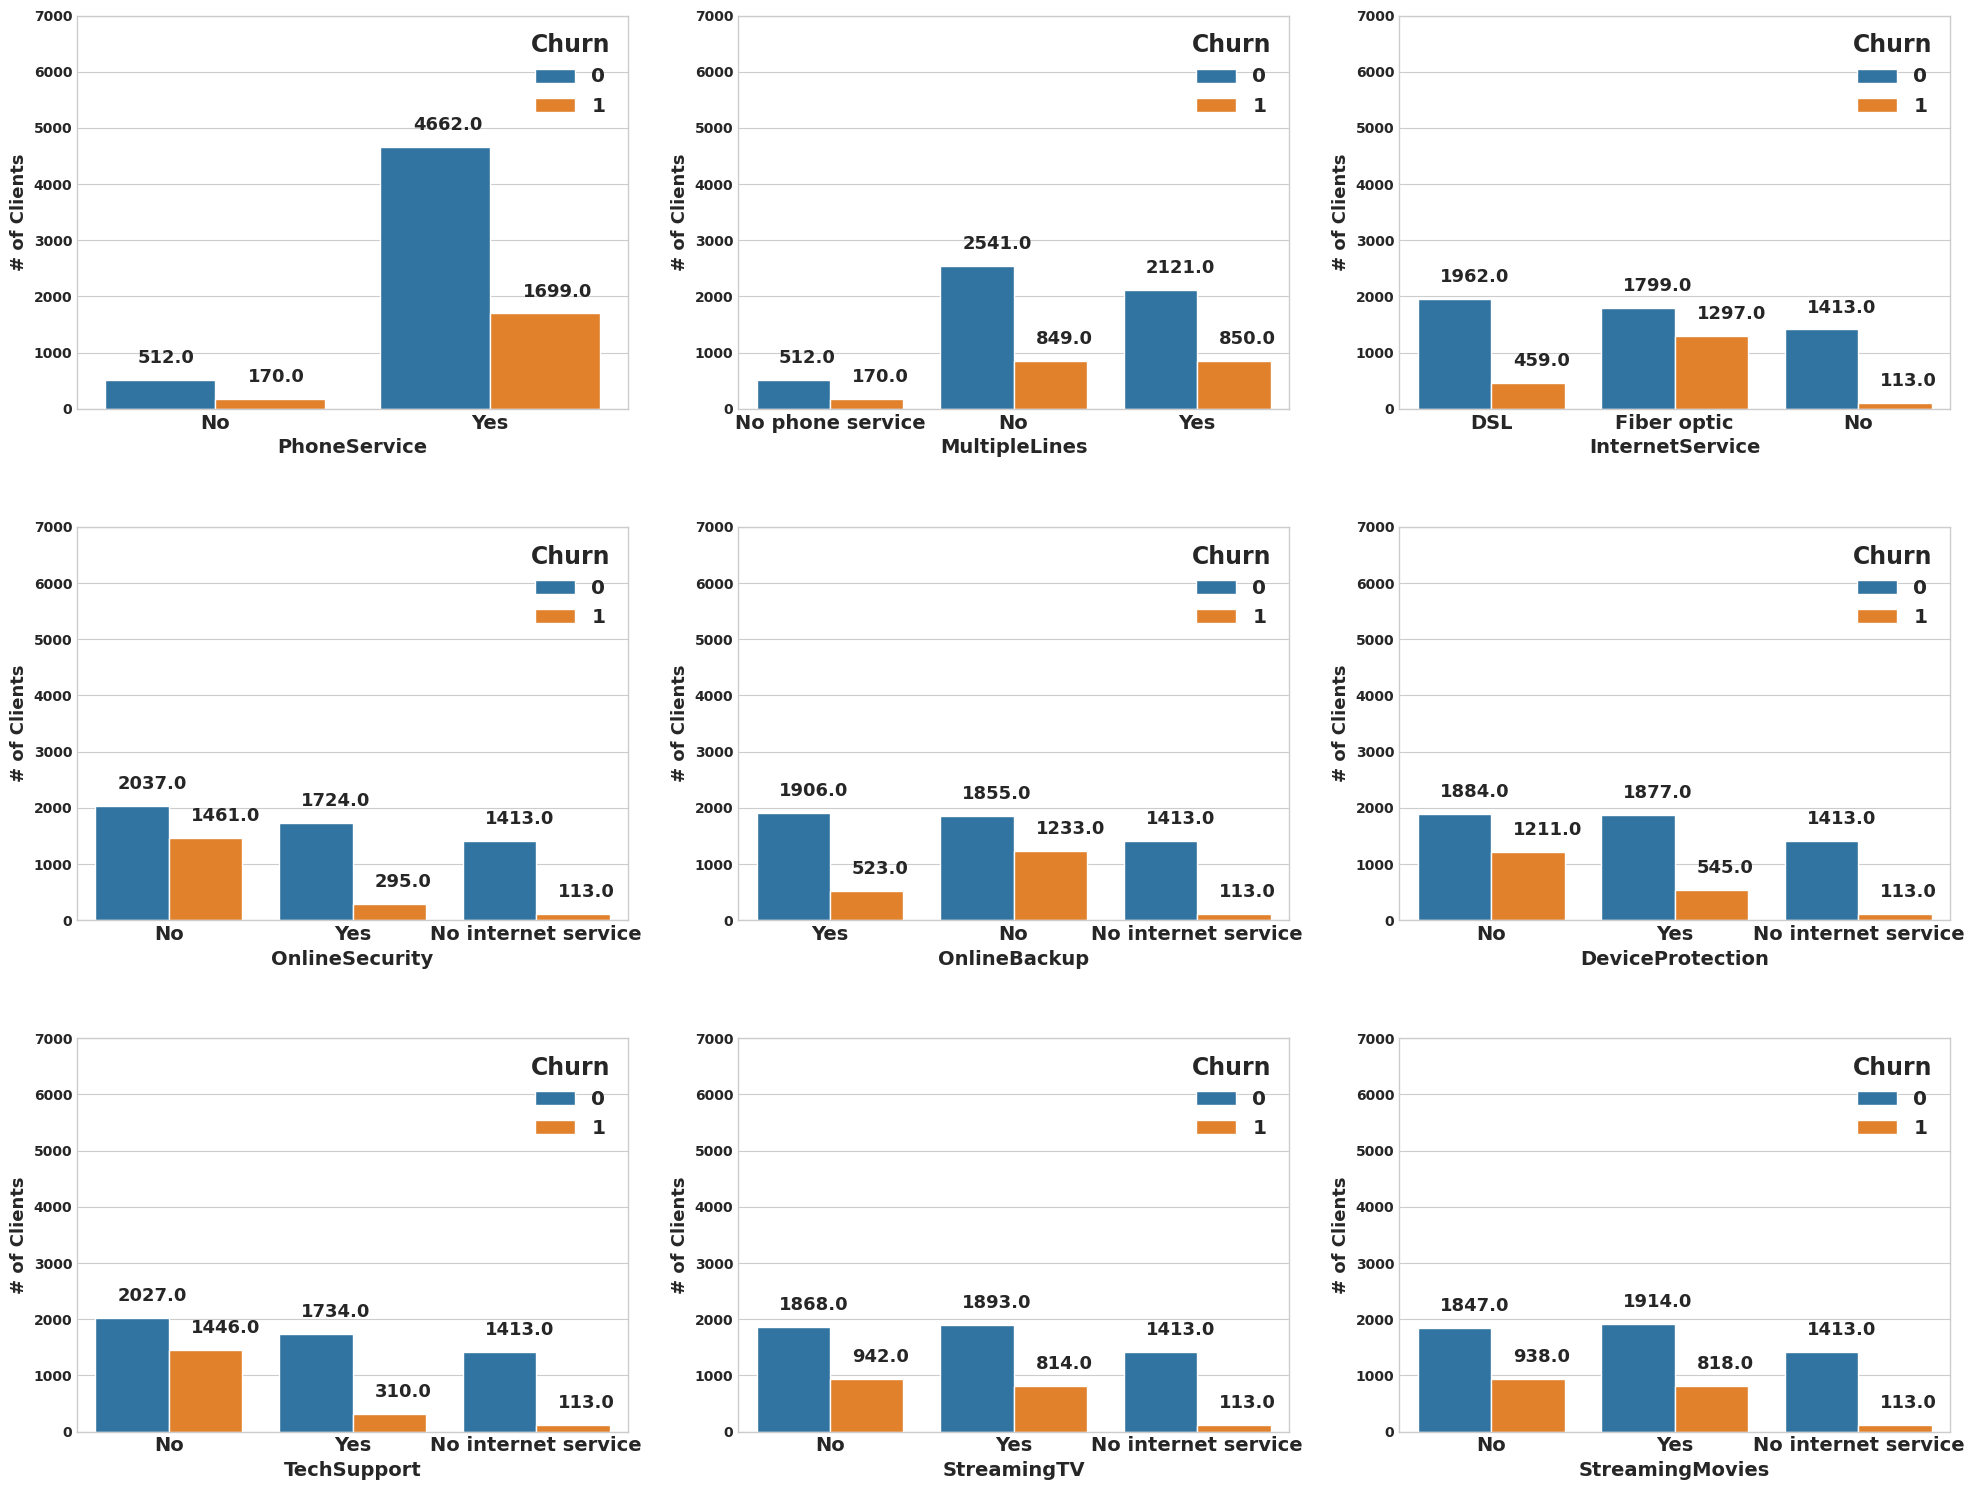

In [41]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(serv_features):    
    plt.subplot(3, 3, i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn")

    plt.xlabel(col, fontsize= 14 , fontweight='bold')
    plt.ylabel("# of Clients", fontsize= 13 , fontweight='bold')
    plt.ylim(0,7000)
    plt.xticks(fontsize= 14 , fontweight='bold')
    
    plt.legend(title = 'Churn', fontsize='x-large', title_fontsize='17')

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.12, p.get_height()+300), fontsize= 13)

# Adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

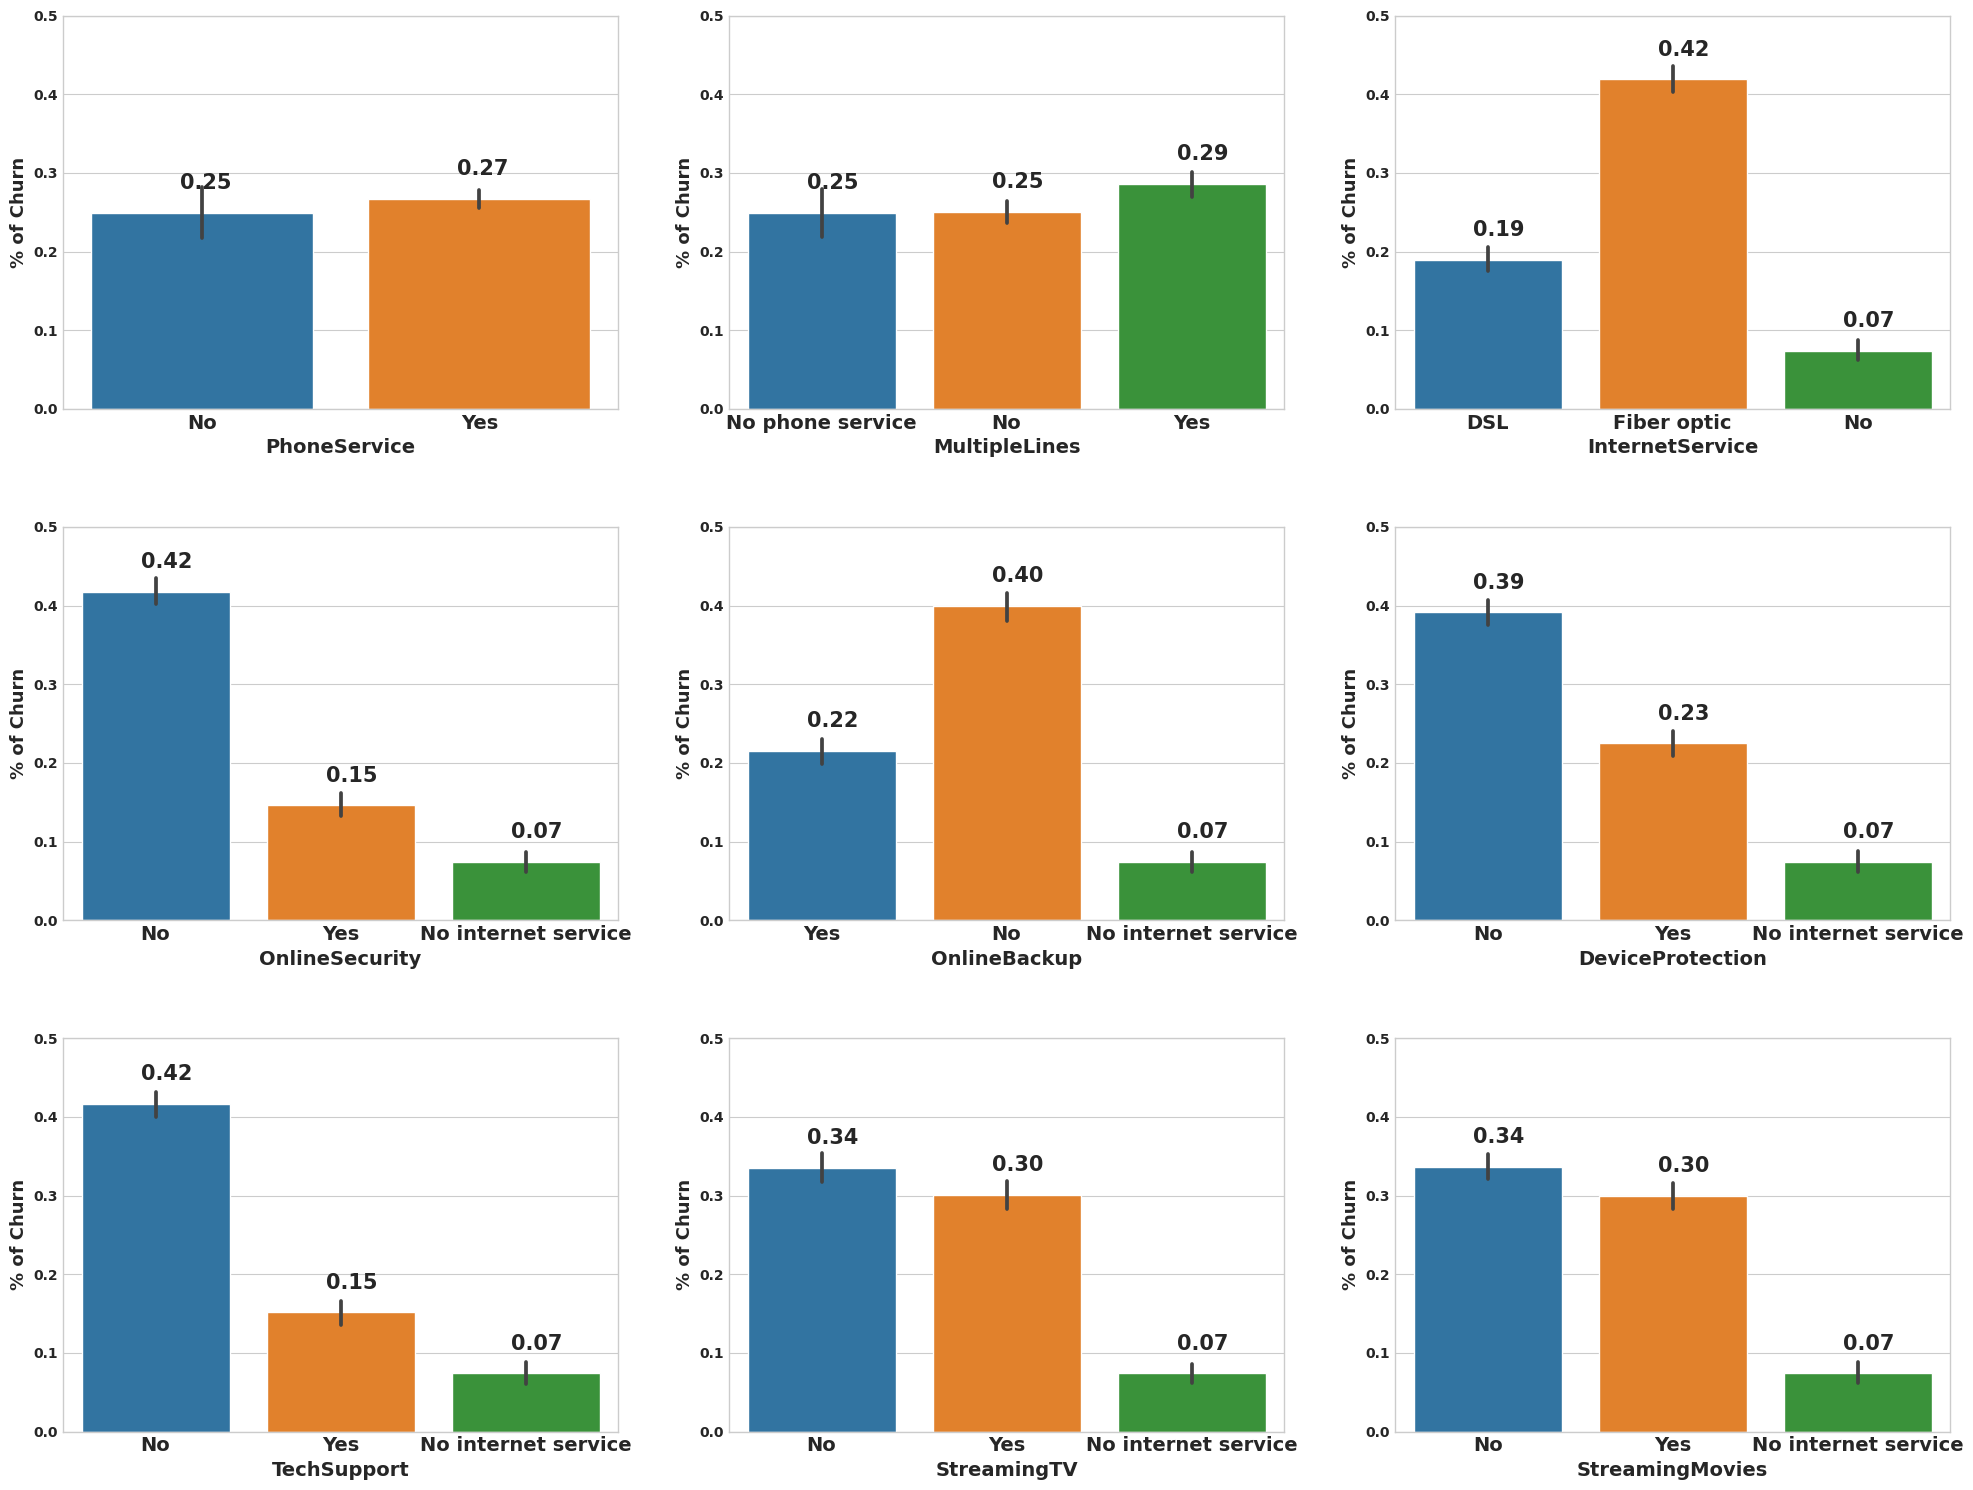

In [43]:
plt.figure(figsize=(20, 15))

for i, col in enumerate(serv_features):    
    plt.subplot(3, 3, i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df)

    plt.xlabel(col, fontsize= 14 , fontweight='bold')
    plt.ylabel("% of Churn", fontsize= 13 , fontweight='bold')
    plt.ylim(0,0.5)
    plt.xticks(fontsize= 14 , fontweight='bold')

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.32, p.get_height()+0.03),fontsize=15)

# Adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3)

plt.show()

* Curiously enough, the difference of churn between clients with and without phone services is quite small, been negligible if we take those with multiple lines out of equation.

* In this group of features, the real game-changing ones in terms of customer retainment are those related to internet services.

* In the feature ‘InternetServices’, the percentage of churn in each category is highly different one from another. Those who don’t subscribe to the company’s internet (presumably, they only use their phone service), are the most likely to endure as their customers. The likelihood of churn from customers with DSL service is also smaller than the overall probability.

* The highest percentage of churn, with over 40%, is from customers with fiber optic internet. Fiber optic tends to be faster than DSL internet, but their subscription is usually more expensive as well. We don't have the information about the fee for each service, but at least we can find the mean value of monthly charges per type of internet just to have an idea that this is the case.

In [44]:
df.groupby(by=['InternetService'])['MonthlyCharges'].mean().sort_values()

InternetService
No             21.079194
DSL            58.102169
Fiber optic    91.500129
Name: MonthlyCharges, dtype: float64

* As expected, the average charges for each service are significantly different, with fiber optic been the most expensive. Without any additional information, it’s hard to draw definitive conclusions, but it seems that the cost-benefit relationship of their fiber optic service is far from been attractive enough to retain customers.

Such a high churn rate might indicate that their service’s quality is subpar in terms of speed and/or reliability. 
* Analyzing complaints received by their customer service call center service to extract useful and specific information about their internet is a must. A survey with a significant group of customers, aiming to understand how they perceive the quality of the service, is another step to find the problem and to help defining the course of action.

As for the other services, the likelihood of churn from customers who have each one of them is actually lower than from those who haven’t. The higher differences are found in ‘TechSupport’ and ‘OnlineSecurity’, while the lower ones are found in the streaming services.

Let’s calculate the average monthly charges from each category in the Tech Support and Online Security features.

In [45]:
print(df.groupby(by=['TechSupport'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['OnlineSecurity'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['OnlineSecurity', 'TechSupport'])['MonthlyCharges'].mean().sort_values())

TechSupport
No internet service    21.079194
No                     74.586683
Yes                    80.680137
Name: MonthlyCharges, dtype: float64 

OnlineSecurity
No internet service    21.079194
No                     75.693067
Yes                    78.838732
Name: MonthlyCharges, dtype: float64 

OnlineSecurity       TechSupport        
No internet service  No internet service    21.079194
No                   No                     74.188367
Yes                  No                     75.692011
No                   Yes                    79.758148
Yes                  Yes                    81.472930
Name: MonthlyCharges, dtype: float64


Both services don’t seem to affect the subscription charges by much. If the company can quantify the cost of providing each service per customer and find out that it is relatively small, they could either reduce the extra subscription fee for those additional services or simply cut that fee and offer those services as standard for internet customers for a trial period. Given that most customers don’t subscribe to those services and given that they have a significant impact on the customer retainment, it’s possible that such strategy could result in a higher profit on the long term.

* Let’s see if the churn rate gets significantly lower for customers who have access to both services.

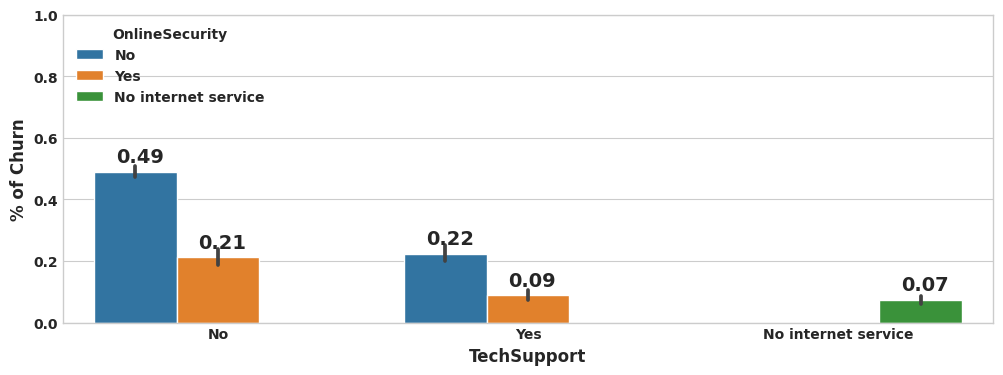

In [46]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "TechSupport", y = "Churn", hue = "OnlineSecurity", data = df)

plt.ylabel("% of Churn", fontsize= 12 , fontweight='bold')
plt.xlabel("TechSupport", fontsize= 12 , fontweight='bold')

plt.ylim(0,1.0)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.070, p.get_height()+0.03),fontsize=14)

plt.show()

The differences in terms of churn rate are quite significant. While customers who don’t use neither of those services have a close to 50% chance of churn, the churn rate for those who have both is lower than 10%, supporting the previous point.



# **Account Information**

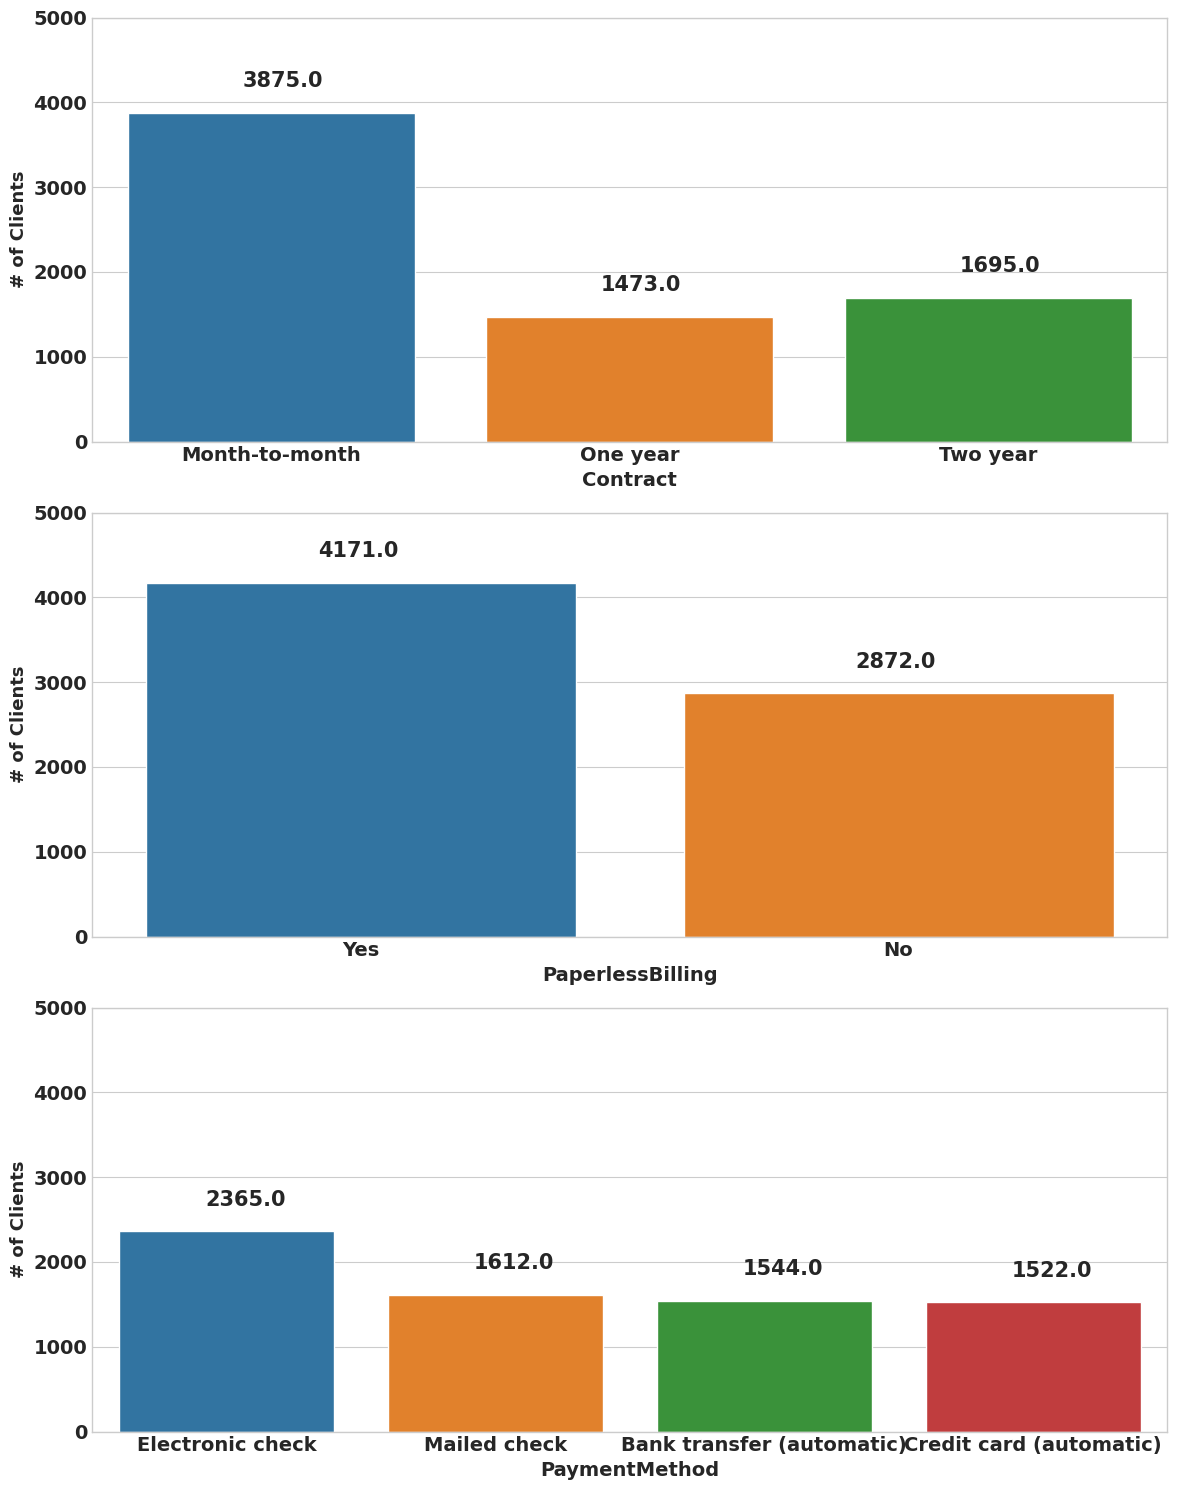

In [65]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.countplot(data = df, x = col)

    plt.xlabel(col, fontsize= 14 ,fontweight='bold')
    plt.ylabel("# of Clients", fontsize= 13 , fontweight='bold')
    plt.ylim(0,5000)
    plt.xticks(fontsize= 14 , fontweight='bold')
    plt.yticks(fontsize= 14, fontweight='bold')

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+300), fontsize= 15)

plt.tight_layout()

plt.show()

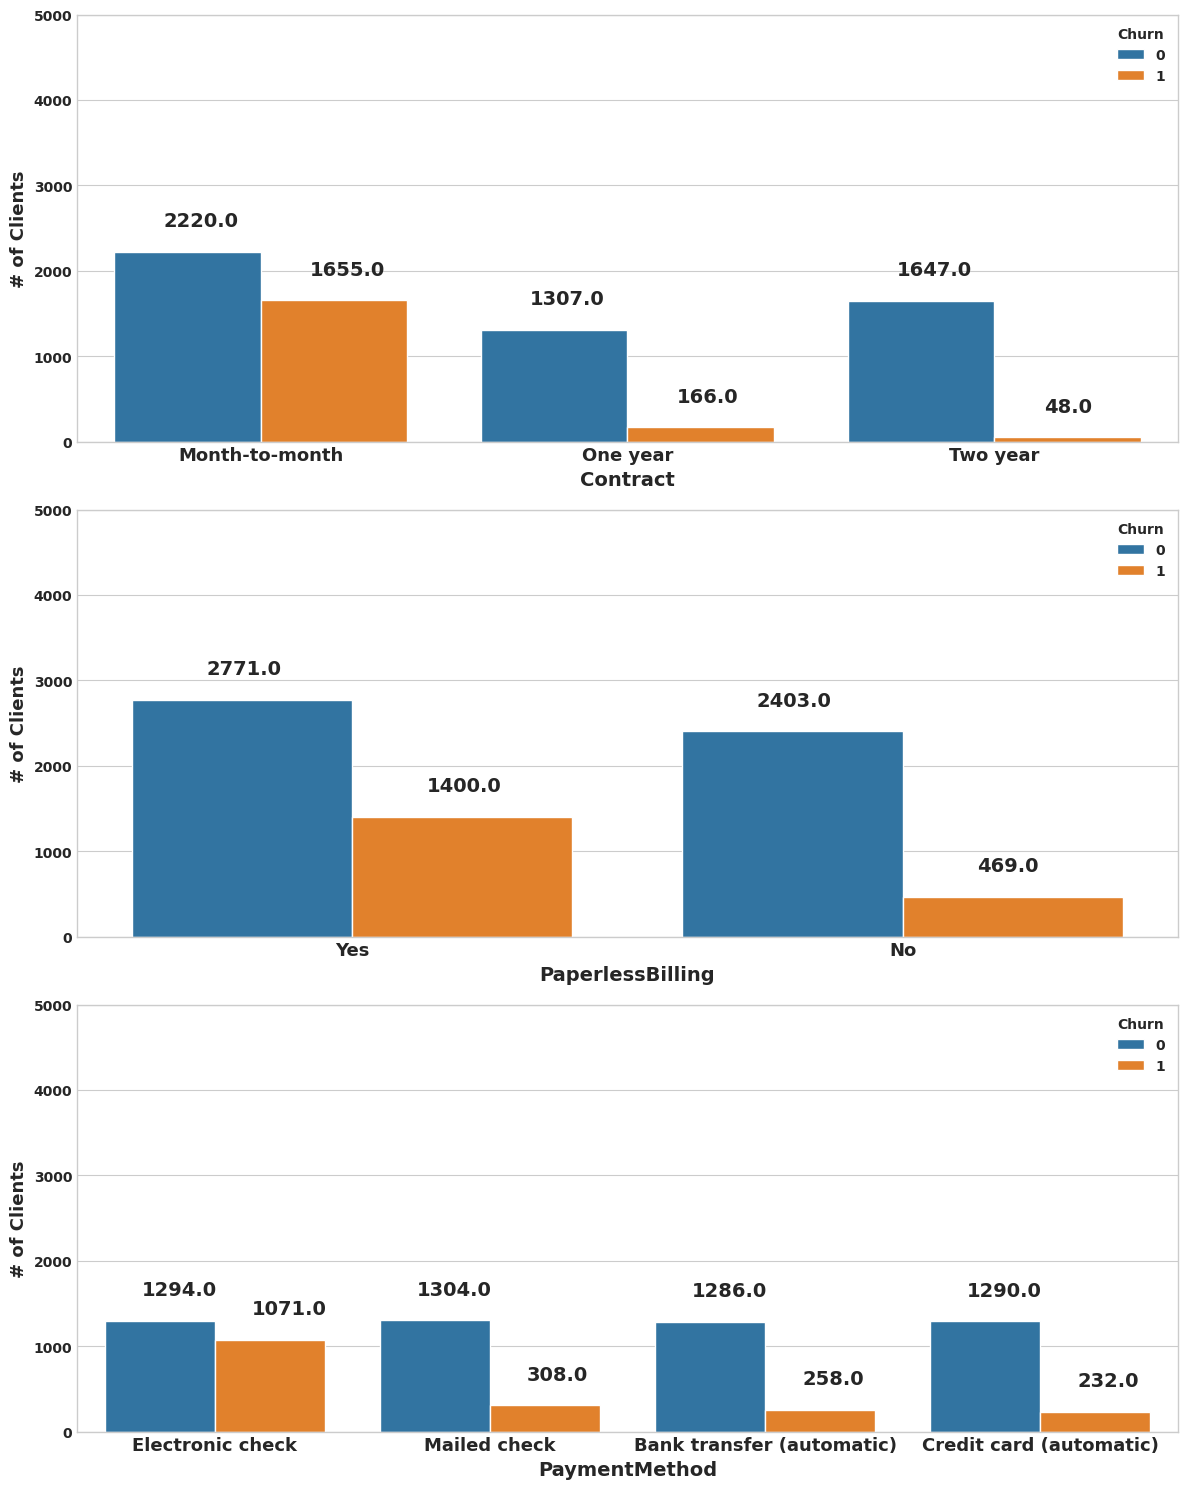

In [67]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.countplot(data = df, x = col, hue="Churn")

    plt.xlabel(col, fontsize= 14 , fontweight='bold')
    plt.ylabel("# of Clients", fontsize= 13 , fontweight='bold')
    plt.ylim(0,5000)
    plt.xticks(fontsize= 13 , fontweight='bold')

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.135, p.get_height()+300), fontsize= 14)

plt.tight_layout()

plt.show()

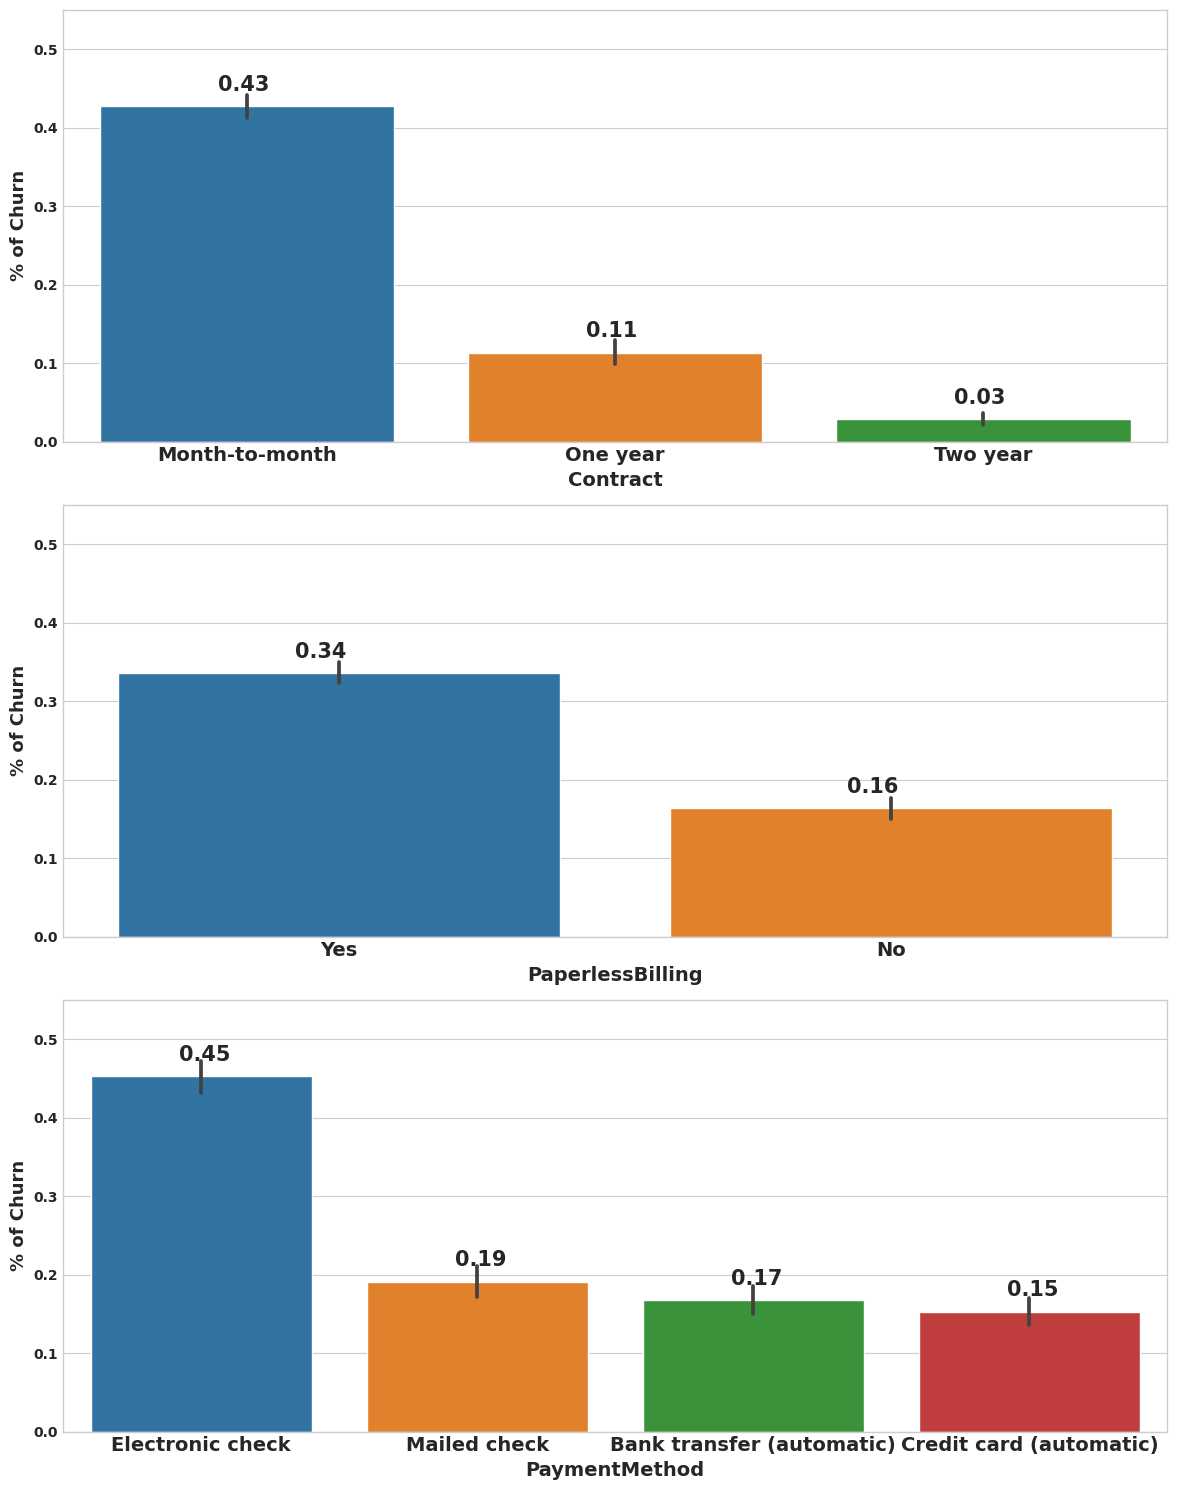

In [68]:
plt.figure(figsize=(12,15))

for i,col in enumerate(cat_accinfo_features):    
    plt.subplot(3,1,i + 1)
    
    ax = sns.barplot(x = col, y = "Churn", data = df)

    plt.xlabel(col, fontsize= 14 , fontweight='bold')
    plt.ylabel("% of Churn", fontsize= 13 , fontweight='bold')
    plt.ylim(0,0.55)
    plt.xticks(fontsize= 14 , fontweight='bold')

    for p in ax.patches:
        ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.32, p.get_height()+0.02),fontsize=15)

plt.tight_layout()

plt.show()

Naturally, in terms of contract, the highest churn rate is from the ‘month-to-month’ type, which is also the most dominant contract. What seems odd is the high chance of churn from customers who choose electronic check as payment method and opts for paperless billing. It could be, for instance, that most customers in the month-to-month contract also fall into those categories. We can check that.

In [69]:
print(df.groupby(by=['Contract'])['PaperlessBilling'].value_counts(normalize = True),' \n')
print(df.groupby(by=['Contract'])['PaymentMethod'].value_counts(normalize = True))

Contract        PaperlessBilling
Month-to-month  Yes                 0.667355
                No                  0.332645
One year        Yes                 0.543109
                No                  0.456891
Two year        No                  0.536873
                Yes                 0.463127
Name: proportion, dtype: float64  

Contract        PaymentMethod            
Month-to-month  Electronic check             0.477419
                Mailed check                 0.230452
                Bank transfer (automatic)    0.152000
                Credit card (automatic)      0.140129
One year        Credit card (automatic)      0.270197
                Bank transfer (automatic)    0.265445
                Electronic check             0.235574
                Mailed check                 0.228785
Two year        Credit card (automatic)      0.342773
                Bank transfer (automatic)    0.332743
                Mailed check                 0.225369
                Electroni

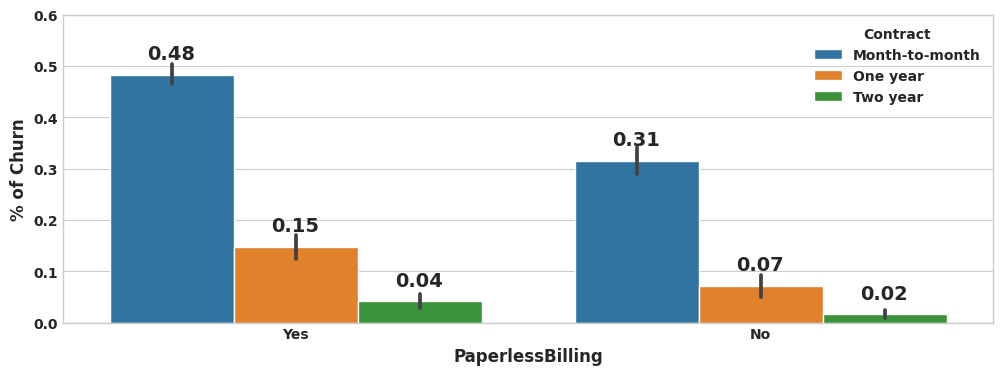

In [70]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "PaperlessBilling", y = "Churn", hue = "Contract", data = df)

plt.ylabel("% of Churn", fontsize= 12 , fontweight='bold')
plt.xlabel("PaperlessBilling", fontsize= 12 , fontweight='bold')

plt.ylim(0,0.6)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.08, p.get_height()+0.03),fontsize=14)

plt.show()

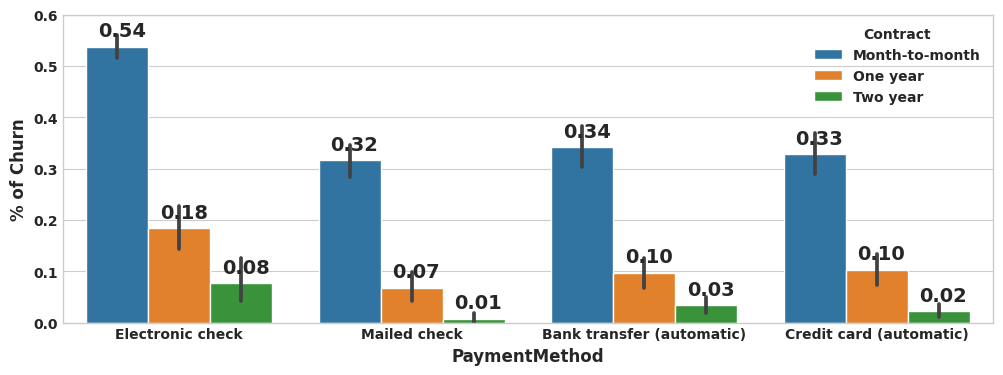

In [72]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "PaymentMethod", y = "Churn", hue = "Contract", data = df)

plt.ylabel("% of Churn", fontsize= 12 , fontweight='bold')
plt.xlabel("PaymentMethod", fontsize= 12 , fontweight='bold')
plt.ylim(0,0.6)

for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.05, p.get_height()+0.020),fontsize=14)

plt.show()

The likelihood of churn is, in fact, higher for those categories, regardless of type of contract. Personally, is hard for me to see a causality, without additional information or domain knowledge, between the churn rate and the way someone receives their bill and choose to pay them. It is more likely that those two features are associated with several others. The internet service, a feature with notable differences of churn rate between each one of its categories, could present some correlation between them.



In [73]:
print(df.groupby(by=['InternetService'])['PaperlessBilling'].value_counts(normalize = True), '\n')
print(df.groupby(by=['InternetService'])['PaymentMethod'].value_counts(normalize = True))

InternetService  PaperlessBilling
DSL              Yes                 0.549360
                 No                  0.450640
Fiber optic      Yes                 0.773579
                 No                  0.226421
No               No                  0.707733
                 Yes                 0.292267
Name: proportion, dtype: float64 

InternetService  PaymentMethod            
DSL              Electronic check             0.267658
                 Mailed check                 0.253201
                 Credit card (automatic)      0.245353
                 Bank transfer (automatic)    0.233788
Fiber optic      Electronic check             0.515181
                 Bank transfer (automatic)    0.208656
                 Credit card (automatic)      0.192829
                 Mailed check                 0.083333
No               Mailed check                 0.485583
                 Bank transfer (automatic)    0.217562
                 Credit card (automatic)      0.216907
       

What stands out here in our grouping operations:

* Customers with Internet Service = ‘No’: Less than 30% receive paperless bills and only 8% pay them with electronic check;
* Customers with Internet Service = ‘Fiber Optic’: 77% receive paperless bills and more them 51% pay them with electronic check.

We can recall that the lowest churn rate in the internet services feature is from those customers who don’t use Telco’s internet, while the highest is found among those who use their fiber optic internet. So, we can say that those results don’t come out as a surprise.

Although we shouldn’t conclude that the payment method or the way the bills are sent have a direct influence in the customer retainment, it is worth to point that those features will probably be useful for our prediction models.

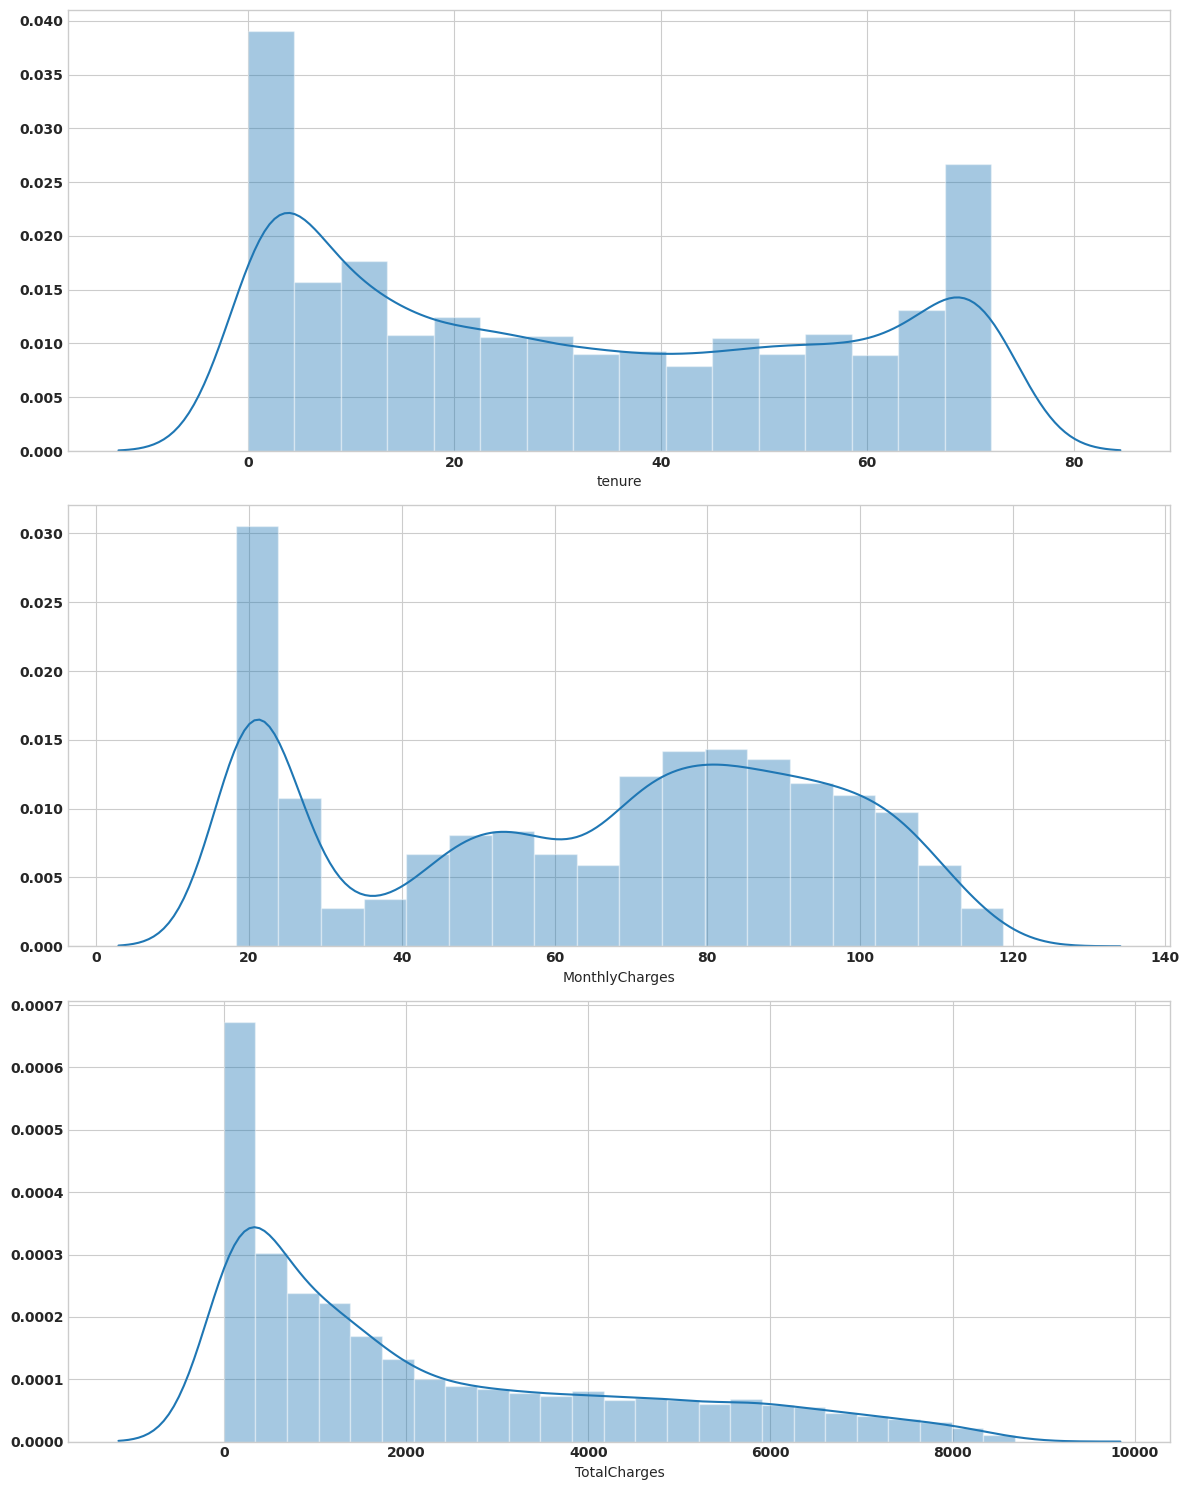

In [74]:
plt.figure(figsize=(12,15))

for i,col in enumerate(num_accinfo_features):    
    plt.subplot(3,1,i + 1)
    sns.distplot(df.loc[:,col])
    plt.ylabel('')
    plt.ylabel('')

    plt.tight_layout()

plt.show()

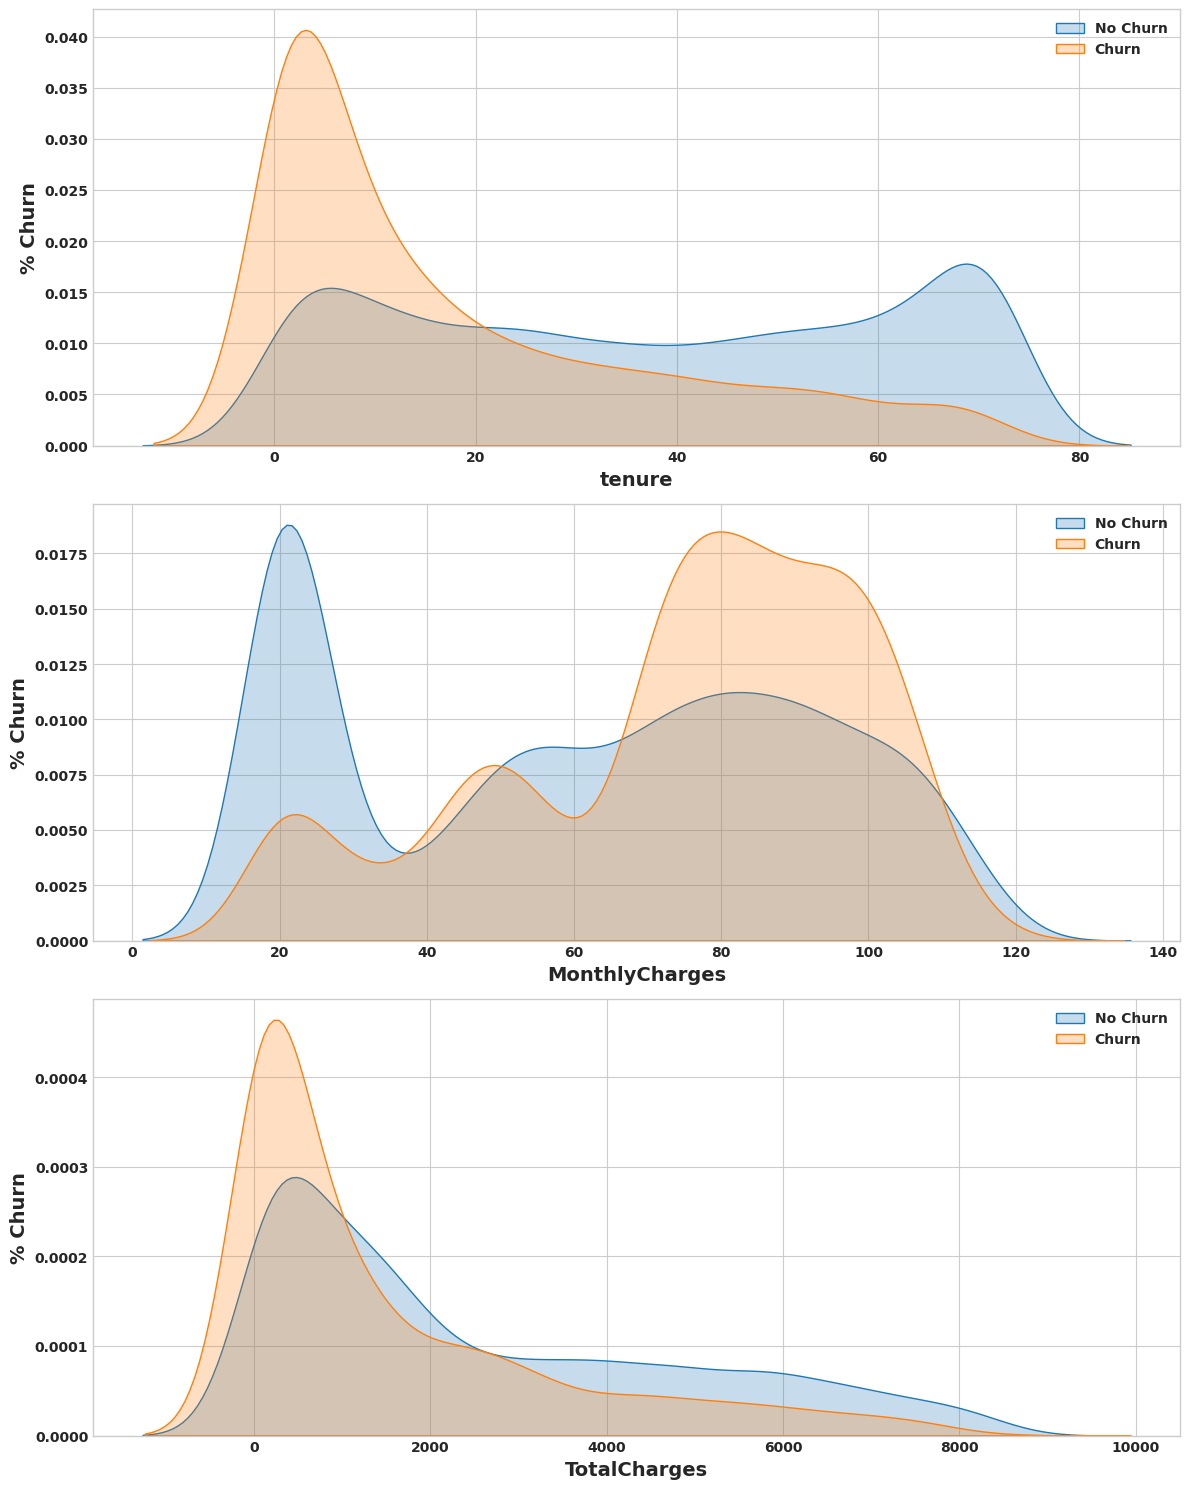

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 15))

for i, col in enumerate(num_accinfo_features):    
    plt.subplot(3, 1, i + 1)
    
    sns.kdeplot(df.loc[(df['Churn'] == 0), col], label='No Churn', shade=True)
    sns.kdeplot(df.loc[(df['Churn'] == 1), col], label='Churn', shade=True)
    
    plt.legend()
    plt.xlabel(col, fontsize=14, fontweight='bold')  # Set x-label bold
    plt.ylabel('% Churn', fontsize=14, fontweight='bold')  # Set y-label bold (even though it's empty)
    
    plt.tight_layout()

plt.show()


In [77]:
print(df.groupby(by=['Churn'])['tenure'].mean().sort_values(), '\n')
print(df.groupby(by=['Churn'])['MonthlyCharges'].mean().sort_values(), '\n')
print(df.groupby(by=['Churn'])['TotalCharges'].mean().sort_values())

Churn
1    17.979133
0    37.569965
Name: tenure, dtype: float64 

Churn
0    61.265124
1    74.441332
Name: MonthlyCharges, dtype: float64 

Churn
1    1531.796094
0    2549.911442
Name: TotalCharges, dtype: float64


As expected, the average tenure period for churned customers is lower and the average monthly charges are higher than the same metrics for retained customers. The average total charges are lower for churned customers, which is probably due to their lower tenure.

The density plot for churned customers in the ‘tenure’ feature showed a high concentration in the first months. Let’s divide this feature in bins to get the churn rate per year of service.

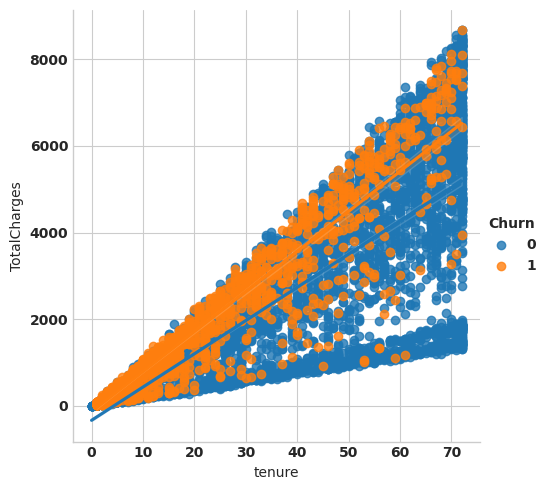

In [90]:
sns.lmplot(x='tenure',y='TotalCharges',hue="Churn",data=df)

In [78]:
df['tenure_bin'] = pd.cut(df['tenure'],[-1,12,24,36,48,60,100])
df['tenure_bin'].value_counts(sort = False)

tenure_bin
(-1, 12]     2186
(12, 24]     1024
(24, 36]      832
(36, 48]      762
(48, 60]      832
(60, 100]    1407
Name: count, dtype: int64

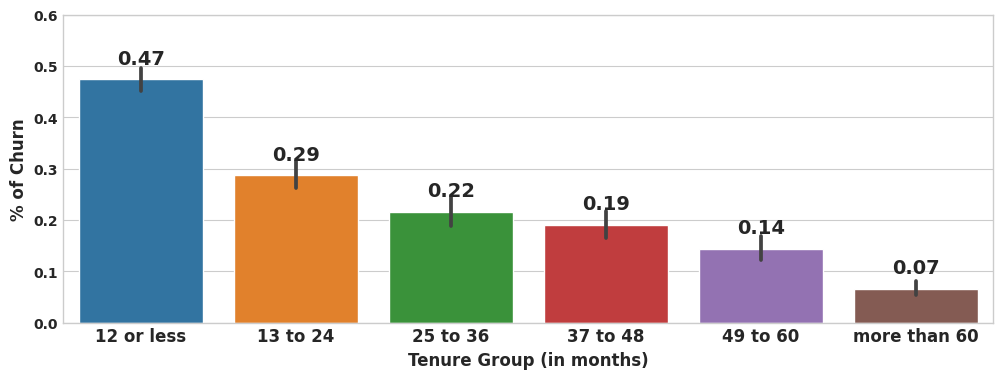

In [79]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "tenure_bin", y = "Churn", data = df)

plt.ylabel("% of Churn", fontsize= 12 , fontweight='bold')
plt.ylim(0,0.6)
plt.xticks([0,1,2,3,4,5], ['12 or less', '13 to 24', '25 to 36', '37 to 48', '49 to 60', 'more than 60'], fontsize = 12 , fontweight='bold')
plt.xlabel("Tenure Group (in months)", fontsize= 12 , fontweight='bold')



for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=14)

plt.show()

Almost 50 percent of those who became a customer for a year or less ended up leaving the company. It’s not unusual to have a higher churn rate in the first year or two for some types of business. Nevertheless, a churn rate this high in the first year indicates that the quality of the service provided fails to hold up to their new customers’ expectation.

# **Feature Engineering**

In [81]:
def number_of_services(row):
    s=0
    if row.OnlineSecurity == "Yes" :
        s+=1
    if row.OnlineBackup == "Yes" :
        s+=1
    if row.DeviceProtection == "Yes" :
        s+=1
    if row.TechSupport == "Yes" :
        s+=1
    if row.StreamingTV == "Yes" :
        s+=1
    if row.StreamingMovies == "Yes" :
        s+=1
    if (row.InternetService == "DSL"or row.InternetService == "Fiber optic") :
        s+=1
    if (row.PhoneService == "Yes") :
        s+=1
    if (row.MultipleLines == "Yes") :
        s+=1
    return s
      
    
x=number_of_services(df.iloc[10,:])
x

3

In [ ]:
def family_size(row):
    s=1
    if row.Partner == "Yes" :
        s+=1
    if row.Dependents == "Yes" :
        s+=1
    return s
      
    
x=family_size(df.iloc[10,:])
x

In [86]:
df['numberOfServices']= df.apply(number_of_services, axis=1)
df['familySize']= df.apply(family_size, axis=1)

In [87]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin,numberOfServices,familySize
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,...,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,"(-1, 12]",2,2
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,...,No,One year,No,Mailed check,56.95,1889.50,0,"(24, 36]",4,1
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,...,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,"(-1, 12]",4,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,...,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,"(36, 48]",4,1
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,...,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,"(-1, 12]",2,1


<Axes: xlabel='numberOfServices', ylabel='TotalCharges'>

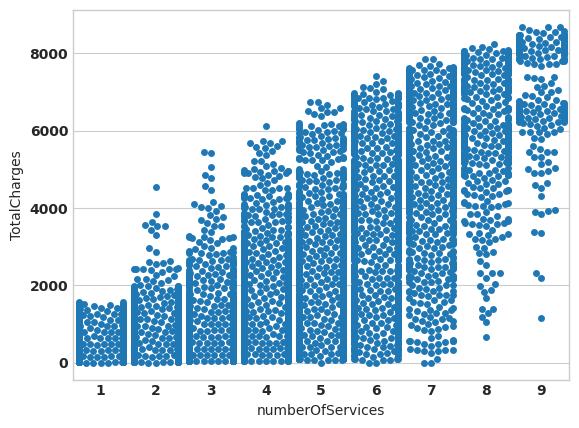

In [88]:
# clients use  services that use 9 Services are higher range in TotalCharges 
sns.swarmplot(x=df['numberOfServices'],y=df['TotalCharges'])

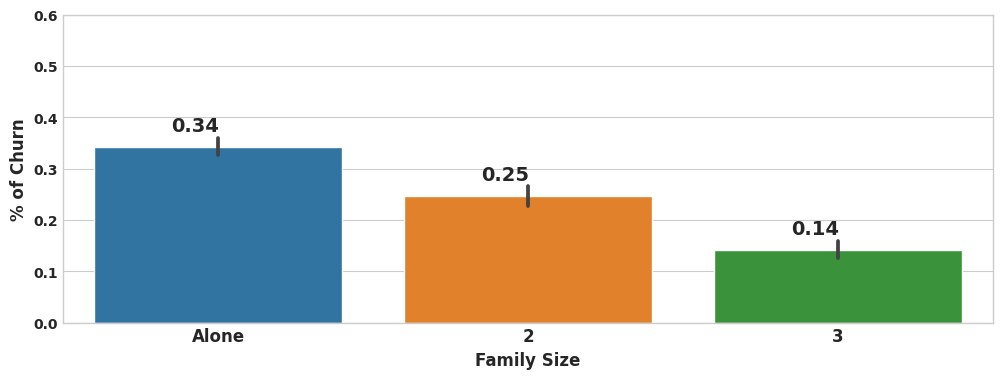

In [103]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "familySize", y = "Churn", data = df)

plt.ylabel("% of Churn", fontsize= 12 , fontweight='bold')
plt.ylim(0,0.6)
plt.xticks([0,1,2], ['Alone', '2', '3'], fontsize = 12 , fontweight='bold')
plt.xlabel("Family Size", fontsize= 12 , fontweight='bold')



for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=14)

plt.show()

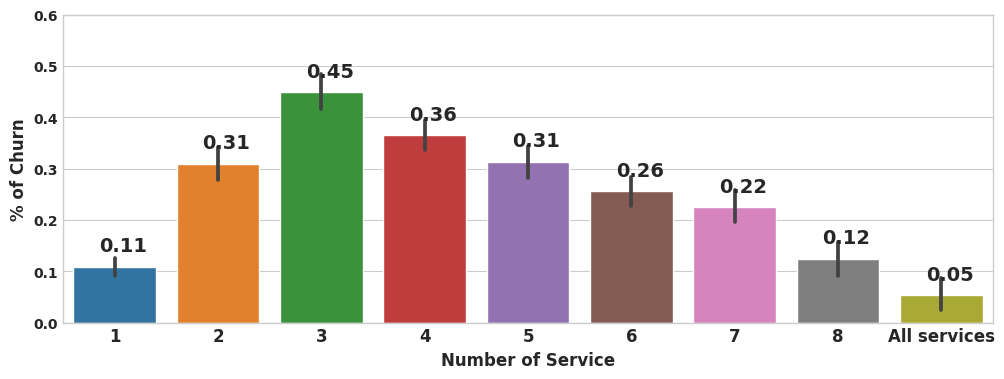

In [105]:
plt.figure(figsize=(12,4))

ax = sns.barplot(x = "numberOfServices", y = "Churn", data = df)

plt.ylabel("% of Churn", fontsize= 12 , fontweight='bold')
plt.ylim(0,0.6)
plt.xticks([0,1,2 ,3,4,5,6,7,8], ['1', '2', '3','4','5','6','7','8','All services'], fontsize = 12 , fontweight='bold')
plt.xlabel("Number of Service", fontsize= 12 , fontweight='bold')



for p in ax.patches:
    ax.annotate("%.2f" %(p.get_height()), (p.get_x()+0.25, p.get_height()+0.03),fontsize=14)

plt.show()

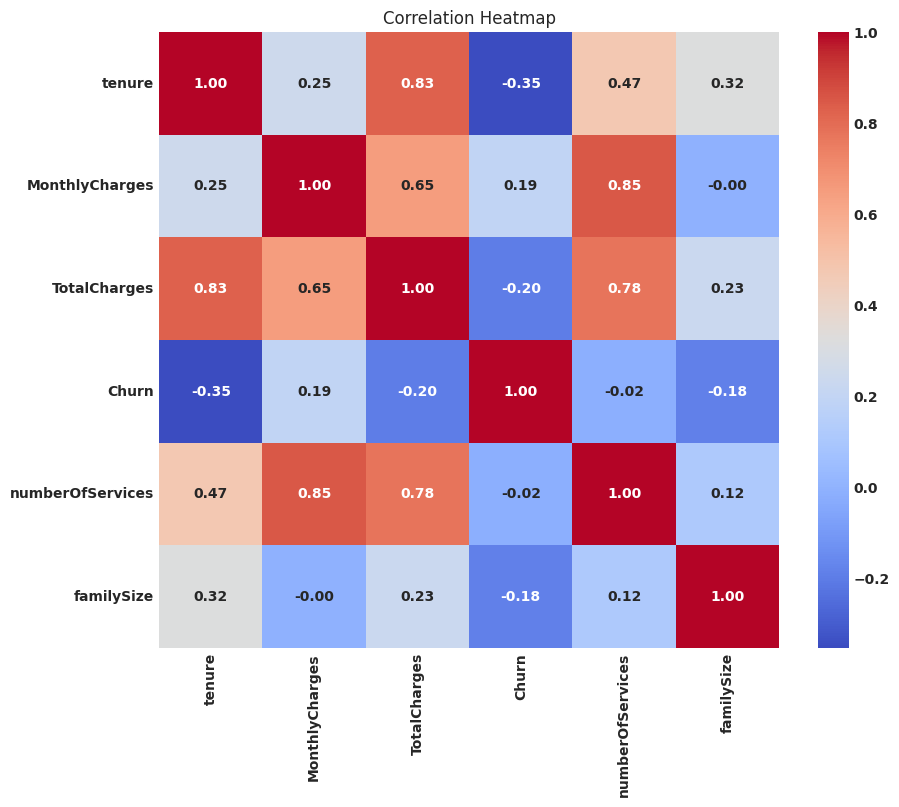

In [114]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()
